In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
import h5py

import dedalus
import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)
logging.getLogger('subsystems').setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')

# Path towards an "almost" fixed point

In [2]:
from scipy.interpolate import RectBivariateSpline

plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.linewidth'] = 1.5

np.set_printoptions(precision=3, suppress=True)

def simulate(params):
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    am = params.get("am", 3.)
    A  = params.get("A",  1/3.)
    B  = params.get("B", -2/3.)
    C  = params.get("C", 0)
    km = params.get("km", 0)
    kE = params.get("kE", 0)
    c0 = params.get("c0", 1.2)
    c1 = params.get("c1", 0.4)

    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    
    #Fixing gauge conditions
    tau_p = dist.Field(name='tau_p')
    tau_v = dist.VectorField(coords, name='tau_u')

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    #Static velocity Problem
    problem = d3.IVP([c, m, v, p, tau_p, tau_v], namespace=locals())
    problem.add_equation("grad(p) - lap(v) - am * div(m) + tau_v = 0") # Stokes equation (with velocity tau term)
    problem.add_equation("div(v) + tau_p = 0")  #Pressure tau term for stokes equation
    problem.add_equation("integ(p) = 0")        #Fix pressure gauge
    problem.add_equation("integ(v) = 0")        #Fix velocity gauge
    
    #Protein fields
    problem.add_equation("dt(c) = 0") #Cadherin is static
    eq_m  = "dt(m) ="
    if params.get('adv', False):
        logger.info('Adding advection term')
        eq_m += " - v @ grad(m)"
    if params.get('cor', False):
        logger.info('Adding co-rotation term')
        eq_m += " -(Ω @ m - m @ Ω)"
    eq_m += " + A * (1 - km * c) * m" #Linear growth/decay
    eq_m += " + B * m * trace(m)" #Higher-order feedback for setting FPs
    eq_m += " + C * (1 - kE * c) * (E @ m + m @ E)" #Mechanical feedback
    problem.add_equation(eq_m)

    #Cadherin initial conditions
    cq = np.zeros_like(c['g'])
    cq[ 0,  0] = c0
    cq[ 1,  1] = c1 / 4
    cq[ 1, -1] = c1 / 4
    cq[-1,  1] = c1 / 4
    cq[-1, -1] = c1 / 4
    c['g'][:] = np.fft.ifft2(cq).real
    c['g'][:] *= cq.shape[-1]**2
    print(c['g'].min(), c['g'].max())
    
    if params.get('use_FP', False):
        t0 = np.load('FPtheta_LBFGS.npy')
        x0 = np.linspace(-Lx/2, Lx/2, t0.shape[-1])
        y0 = np.linspace(-Ly/2, Ly/2, t0.shape[-2])
        theta = RectBivariateSpline(x0, y0, t0.T)(x, y)
        m0 = -A / B * (1 - km * c['g'][:])
        m['g'][0,0,:,:] = np.cos(theta)**2
        m['g'][0,1,:,:] = np.cos(theta)*np.sin(theta)
        m['g'][1,0,:,:] = m['g'][0,1,:,:]
        m['g'][1,1,:,:] = np.sin(theta)**2
        m['g'][:] *= m0
    else:
        #Myosin initial conditions
        m["g"][0,0,:,:] = 0
        m["g"][0,1,:,:] = 0
        m["g"][1,0,:,:] = 0
        m["g"][1,1,:,:] = 0.05

    v["g"][:] = 0
    
    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = params['max_time']
    analysis = solver.evaluator.add_file_handler(f'FixedPoint', 
                                                 iter=params['save_every'])
    analysis.add_tasks(solver.state, layout='g')
    
    # Main loop
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            solver.step(params['timestep'])
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                logger.error("computation diverges: adjust dt and/or dx")
                raise Exception("computation diverges: adjust dt and/or dx")
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}")
    except Exception as e:
        logger.error("Exception raised, triggering end of main loop.")
        raise e
    finally:
        with analysis.get_file() as h5f:
            prms = h5f.create_group('params')
            for key in params:
                prms[key] = params[key]
            

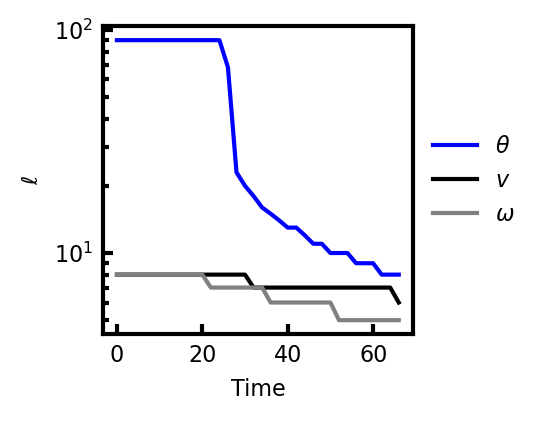

In [49]:
def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    m = mij[..., 0, 0] + mij[..., 1, 1]
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def get_log_spectrum(f, cutoff=1e-7):
    fq = np.fft.fft2(f)
    fq = np.fft.fftshift(fq, axes=(-2, -1))
    fq = np.abs(fq)**2
    fq[fq < cutoff * np.max(fq) / np.prod(fq.shape)] = 0
    fq = np.log(fq)
    return fq

def get_spectral_colormap(f):
    #Find leading-order modes
    fq = np.fft.fftshift(f, axes=(-2, -1))
    fs = np.array([fq[0, 0], fq[1, 1], fq[1, -1], fq[-1, 1], fq[-1, -1]])
    fs = fs[fs != -np.inf]
    if len(fs) == 0:
        return 0, 0
    vmax = np.max(fs)
    vhlf = np.min(fs)
    if (vmax - vhlf) < 1e-2:
        vhlf = vmax - 1
    vmin = vhlf - (vmax - vhlf)
    return vmin, vmax
    
def plot(tt, skip=1, show_cadherin=False):
    with h5py.File(f'FixedPoint/FixedPoint_s1.h5', 'r') as h5f:
        #Collect data
        t0  = h5f['scales/sim_time'][()]
        t0 = t0 - t0.min()
        idxs = [np.argmin(np.abs(t0 - ti)) for ti in tt]

        fig, ax = plt.subplots(2, 1, dpi=200, figsize=(3, 3), sharex=True)
        ax[0].plot(t0, np.mean(np.linalg.norm(h5f['tasks/m'], axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick')    
        ax[1].plot(t0, np.mean(np.linalg.norm(h5f['tasks/v'], axis=1), axis=(1, 2)), 
                   color='black')

        ax[0].set_ylabel(r"$\langle|\!|m|\!|\rangle$")
        ax[1].set_ylabel(r"$\langle|\!|v|\!|\rangle$")
        ax[1].set_xlabel('Time')
        
        for a in ax:
            a.tick_params(which='both', direction='in', width=1.5)
            for t in tt:
                a.axvline(t, linestyle='--', color='grey', linewidth=0.5)
        fig.subplots_adjust(hspace=0)

        x = np.linspace(0, 1, h5f['tasks/m'].shape[-2])
        y = np.linspace(0, 1, h5f['tasks/m'].shape[-1])  
        X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
        twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
        qmap = plt.cm.Reds
        qmap.set_bad(qmap(0))
        
        #Plot myosin
        fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
        for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
        ax[0, 0].set_ylabel('Myosin')
        ax[1, 0].set_ylabel('Myosin spectrum')
        mij = h5f['tasks/m'][idxs]
        mq  = get_log_spectrum(mij[:, 1, 1])
        for i, idx in enumerate(idxs):
            ax[0, i].set_title(f't = {t0[idx]:g}')

            m, n = get_director_magnitude(mij[i])
            vmin, vmax = np.min(m), np.max(m)
            ax[0, i].pcolormesh(x, y, m.T, 
                                cmap='inferno', vmin=vmin, vmax=vmax)
            ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
            qmin, qmax = get_spectral_colormap(mq[i])
            ax[1, i].pcolormesh(x, y, mq[i].T, 
                                cmap=qmap, vmin=qmin, vmax=qmax)
        
        fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
        for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
        ax[0, 0].set_ylabel('Velocity')
        ax[1, 0].set_ylabel('Velocity spectrum')
        
        vi = h5f['tasks/v'][idxs]
        vq = get_log_spectrum(vi[:, 1])
        vmin, vmax = 0, np.max(np.linalg.norm(vi, axis=1))
        for i, ti in enumerate(tt):
            ax[0, i].pcolormesh(x, y, np.linalg.norm(vi[i], axis=0).T, 
                                cmap='YlOrRd', vmin=vmin, vmax=vmax)
            ax[0, i].quiver(X, Y, vi[i, 0, ::skip, ::skip].T, vi[i, 1, ::skip, ::skip].T, 
                            color="black")
            qmin, qmax = get_spectral_colormap(vq[i])
            ax[1, i].pcolormesh(x, y, vq[i].T,
                                cmap=qmap, vmin=qmin, vmax=qmax)

            
        if show_cadherin:
            fig, ax = plt.subplots(2, len(tt), dpi=300, figsize=(2*len(tt), 4))       
            for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')
            ax[0, 0].set_ylabel('Cadherin')
            ax[1, 0].set_ylabel('Cadherin spectrum')
            c = h5f['tasks/c'][idxs]
            cq = get_log_spectrum(c)
            vmin, vmax = np.min(c), np.max(c)
            print(vmin, vmax)
            for i, idx in enumerate(idxs):
                ax[0, i].pcolormesh(x, y, c[i].T, 
                                    cmap='viridis', vmin=vmin, vmax=vmax)
                qmin, qmax = get_spectral_colormap(cq[i])
                ax[1, i].pcolormesh(x, y, cq[i].T,
                                    cmap=qmap, vmin=qmin, vmax=qmax)

def spatial_correlation(x):
    x = x.reshape([x.shape[0], -1, *x.shape[-2:]])
    Ftx = np.fft.fft2(x)
    prod = Ftx * np.conjugate(Ftx)
    prod = prod.sum(axis=-3)
    pt2 = np.fft.ifft2(prod).real
    pt2 = pt2 / pt2[:, 0:1, 0:1]
    return 2 * pt2 - 1

def vec_to_scalar_func(grid, d=1):
    x, y, = np.mgrid[:grid.shape[-2], :grid.shape[-1]]
    mag = np.sqrt(x**2 + y **2)
    mxv = np.max(mag)
    vls = np.arange(0., mxv, d)
    ret = np.zeros([grid.shape[0], int(mxv // d) + 1]) 
    
    for i in range(ret.shape[1]):
        ret[:, i] = np.mean(grid[:, np.abs(mag - vls[i]) <= d / 2.], axis=1)
    ret[np.isnan(ret)] = 0.
    return ret

def half_length(tpr):
    ret = []
    for t in tpr:
        try:
            ret.append(np.argwhere(t< 0.5)[0])
        except:
            ret.append(tpr.shape[-1])
    return np.array(ret)
                
def plot_correlations(savename=None):
     with h5py.File(f'FixedPoint/FixedPoint_s1.h5', 'r') as h5f:
        #Collect data
        t0  = h5f['scales/sim_time'][()][1:]
        t0 = t0 - t0.min()        
        
        m = np.einsum('tiiyx->tyx', h5f['tasks/m'][1:])
        Q = h5f['tasks/m'][1:] / m[:, None, None]
        V = h5f['tasks/v'][1:][()]
        W = np.gradient(V[:, 1], axis=-1) - np.gradient(V[:, 0], axis=-2)
        
        scM = spatial_correlation(m)
        scQ = spatial_correlation(Q)
        scV = spatial_correlation(V)
        scW = spatial_correlation(W)
        
        scM = half_length(vec_to_scalar_func(scM))
        scQ = half_length(vec_to_scalar_func(scQ))
        scV = half_length(vec_to_scalar_func(scV))
        scW = half_length(vec_to_scalar_func(scW))
        
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2, 2))
        #ax.plot(t0, scM, label=r'$m$', color='firebrick')
        ax.plot(t0, scQ, label=r'$\theta$', color='blue',)
        ax.plot(t0, scV, label=r'$v$', color='black')
        ax.plot(t0, scW, label=r'$\omega$', color='grey')
        
        ax.set_yscale('log')
    
        ax.set_xlabel('Time')
        ax.set_ylabel('$\ell$')
        ax.legend(framealpha=False, loc='center left', bbox_to_anchor=[1, 0.5])
        ax.tick_params(which='both', direction='in', width=1.5)

        if savename is not None:
            np.save(savename, scQ.astype(float))
        
plot_correlations()

## 1. Establish a cadherin pattern with low-order harmonics

Compute the fixed point while neglecting contributions from the convective derivative

$$ \dot{m}_{ij} = A[1 - k c] m_{ij} + B m_{ij} \text{Tr}(m) $$

$$ \text{Tr}(m_0) = -\frac{A}{B} [ 1 - k c] $$

Here, we establish a cadherin pattern with the spectrum 

\begin{equation}
    c(\mathbf{q}) = \begin{cases}
       c_0 ,& \mathbf{q} = 0 \\
       c_1 / 4 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

The corresponding fixed point has the spectrum
\begin{equation}
    m_{yy}(\mathbf{q}) = \begin{cases}
       -\frac{A}{B} (1 - k\, c_0) ,& \mathbf{q} = 0 \\
       \frac{A k}{4B} c_1 ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

\begin{equation}
    \mathbf{v}(\mathbf{q}) = \begin{cases}
       \frac{i \alpha A k}{16 \mu B} c_1 \begin{pmatrix} -q_x \\ q_y \end{pmatrix}
           ,& \mathbf{q} = (\pm 1, \pm 1) \\
       0 ,& \text{otherwise}
    \end{cases}
\end{equation}

0.7999999999999999 1.6
2023-06-29 17:17:15,322 __main__ 0/1 INFO :: Starting main loop
2023-06-29 17:17:15,369 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-29 17:17:15,673 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-29 17:17:15,973 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-29 17:17:16,272 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-29 17:17:16,560 solvers 0/1 INFO :: Simulation stop time reached.
0.799999999999997 1.5999999999999996


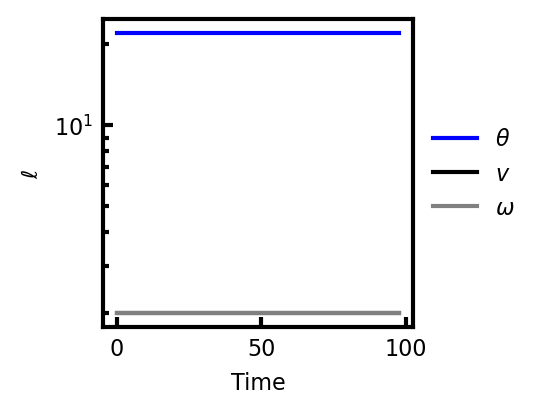

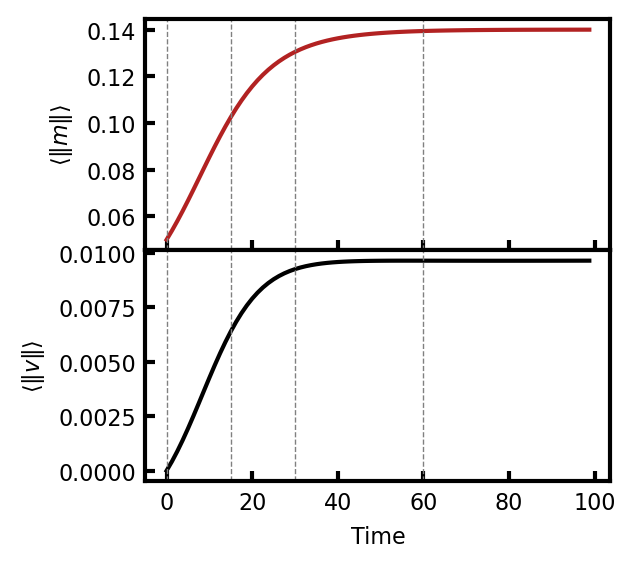

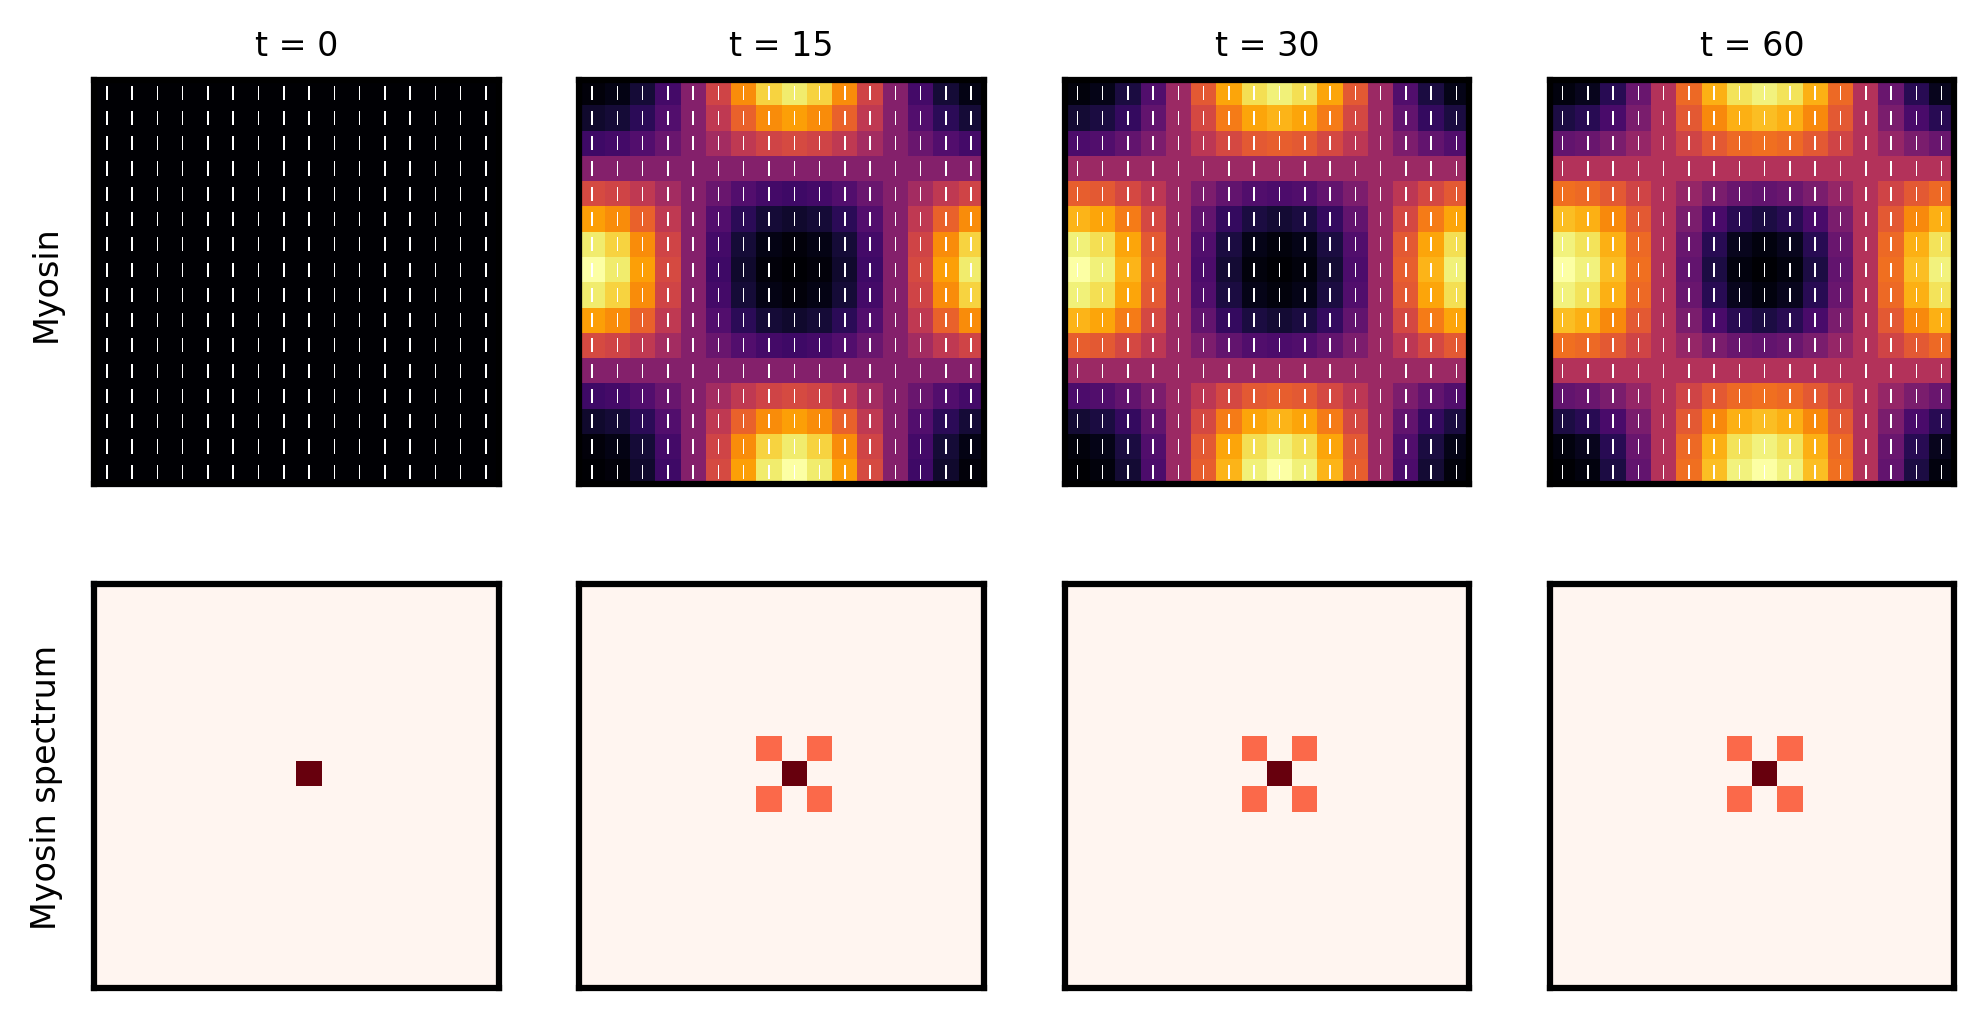

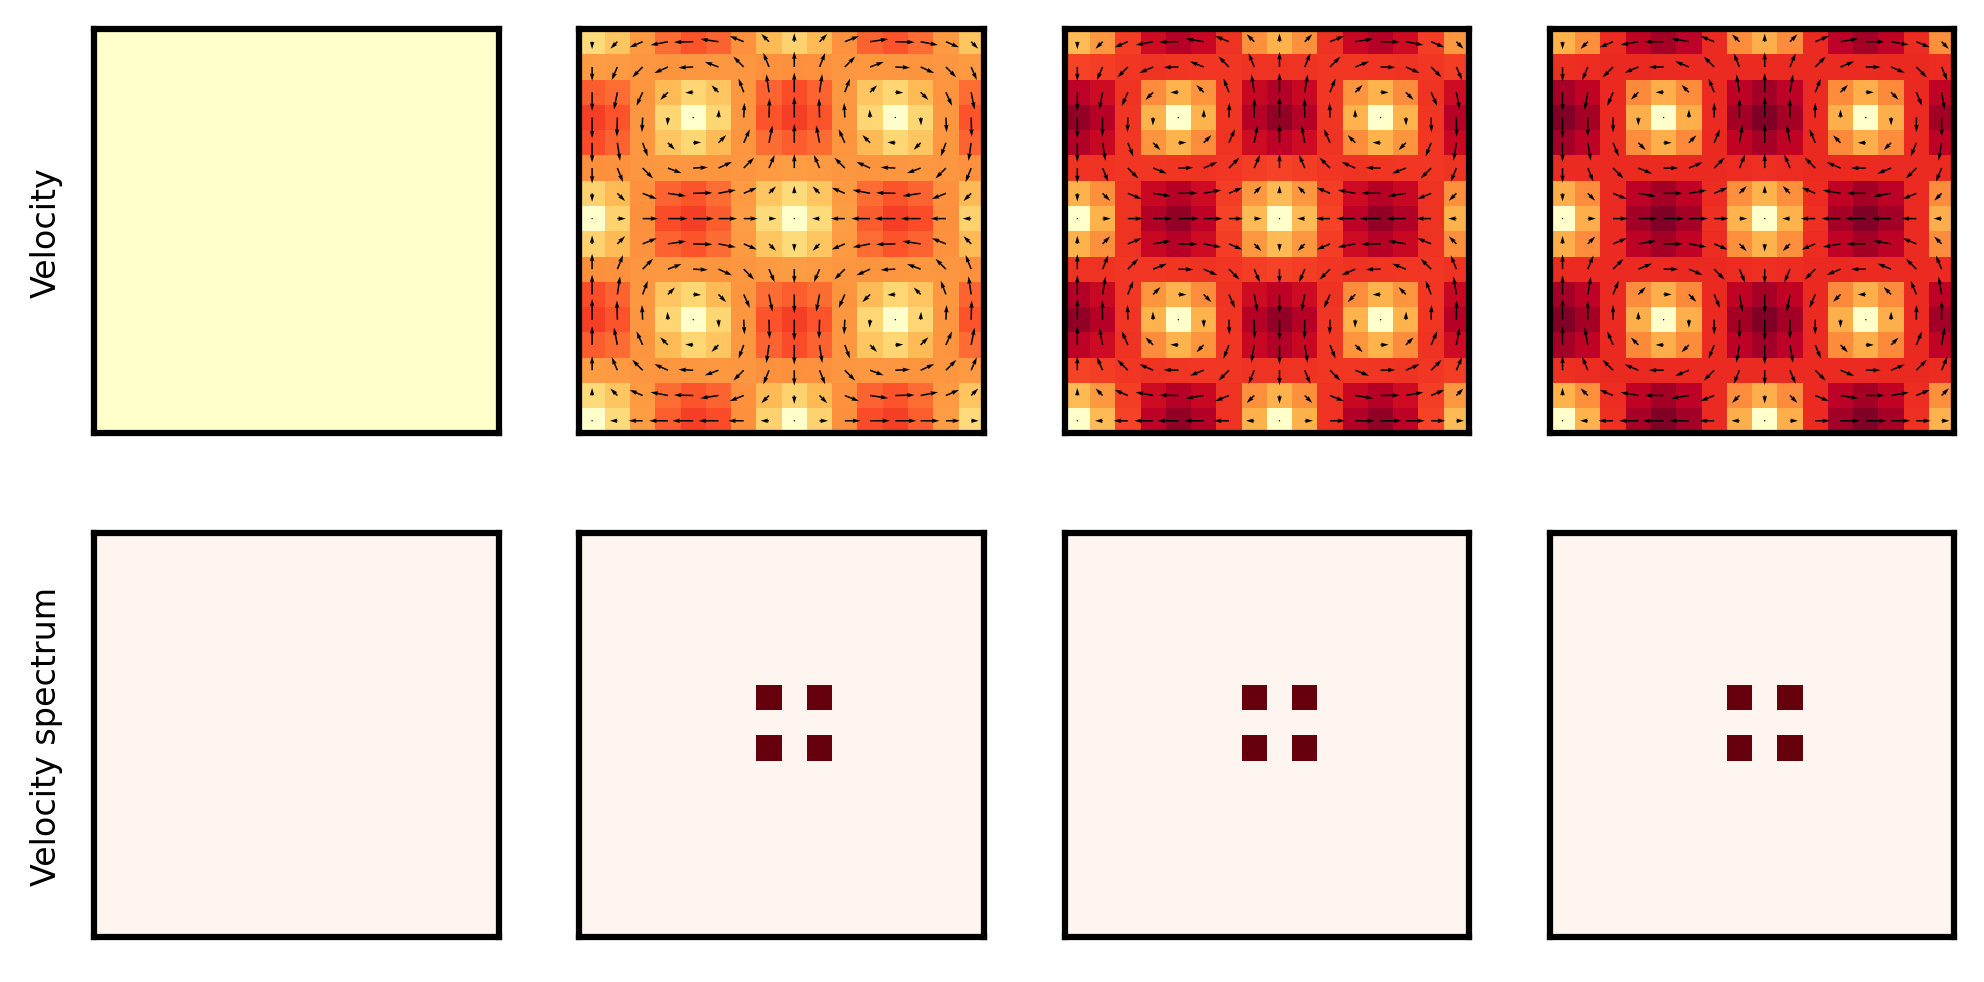

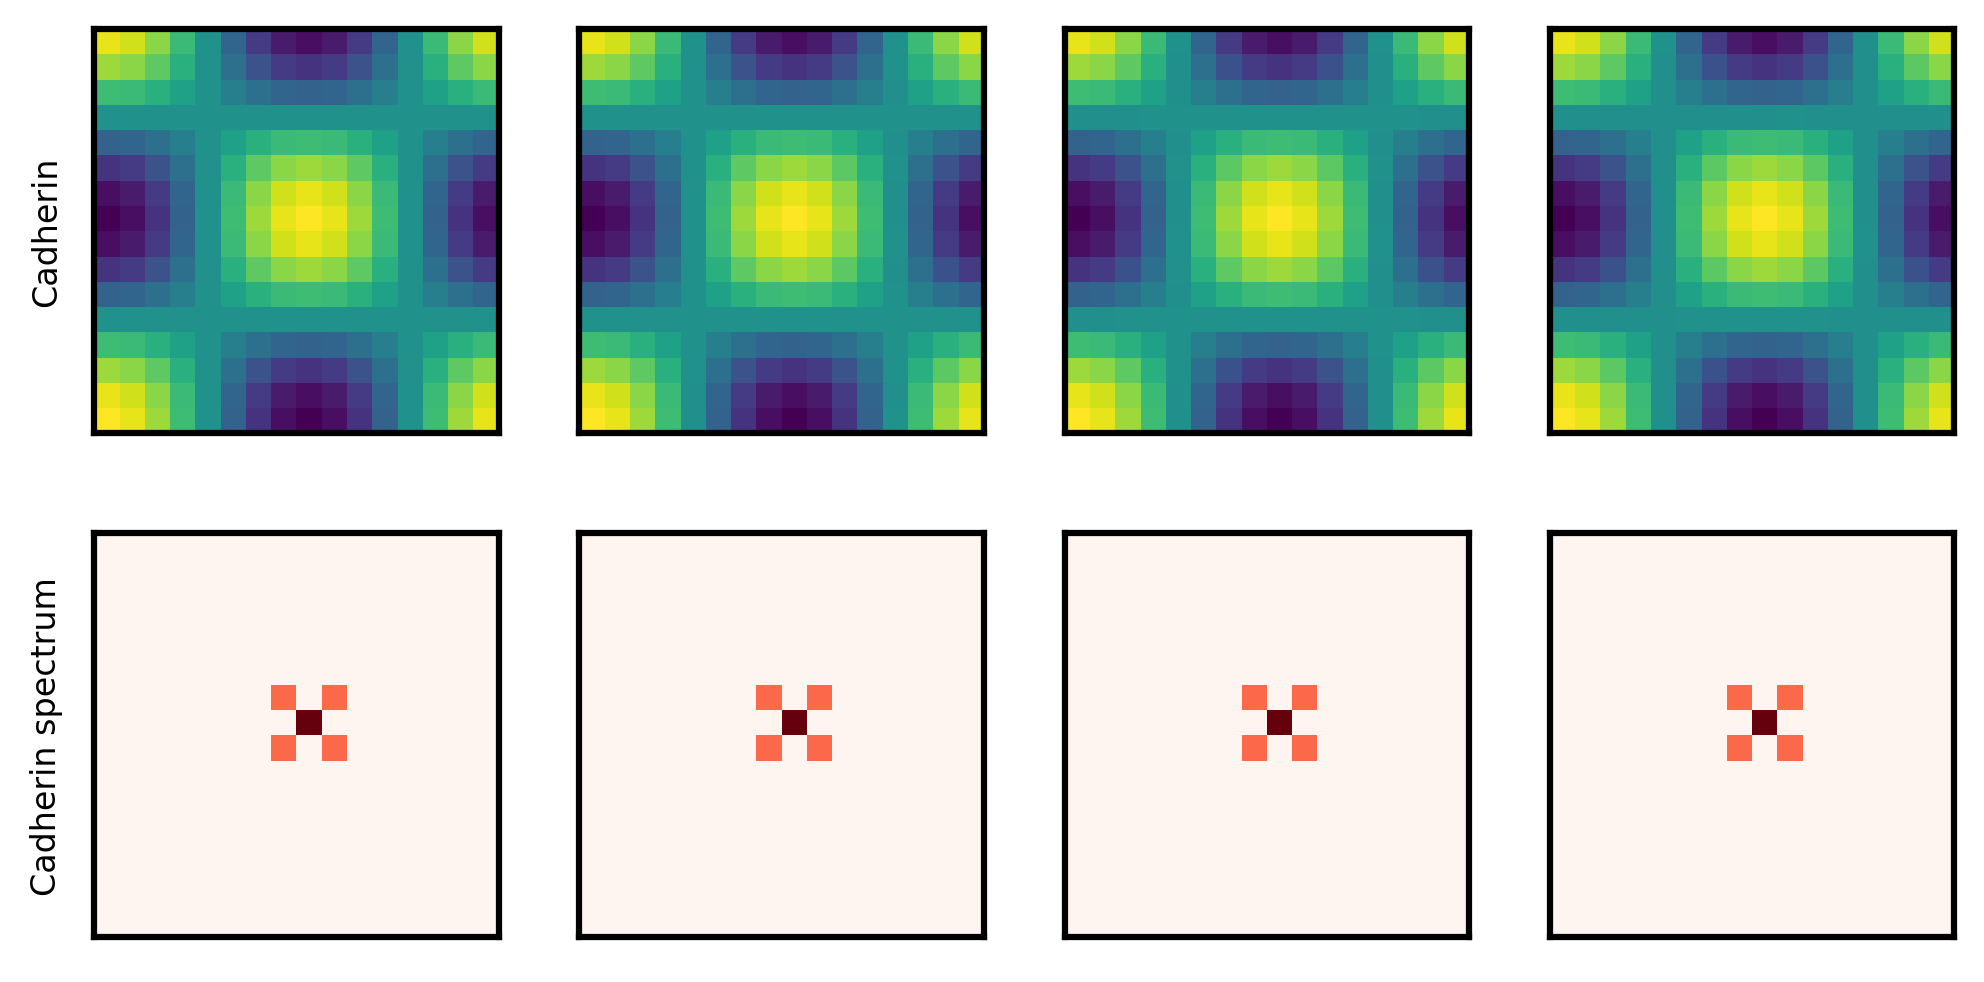

In [102]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3, c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 0.,
    km = 0.6, kE = 0., 
    max_time=100, timestep=0.25, save_every=5,
)

simulate(params)
plot_correlations()
plot([0, 15, 30, 60], show_cadherin=True)

### Plot for Box 3

0.7999999999999999 1.6
2023-06-30 11:14:44,722 __main__ 0/1 INFO :: Starting main loop
2023-06-30 11:14:44,801 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-30 11:14:45,546 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-30 11:14:46,291 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-30 11:14:47,102 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-30 11:14:47,830 solvers 0/1 INFO :: Simulation stop time reached.


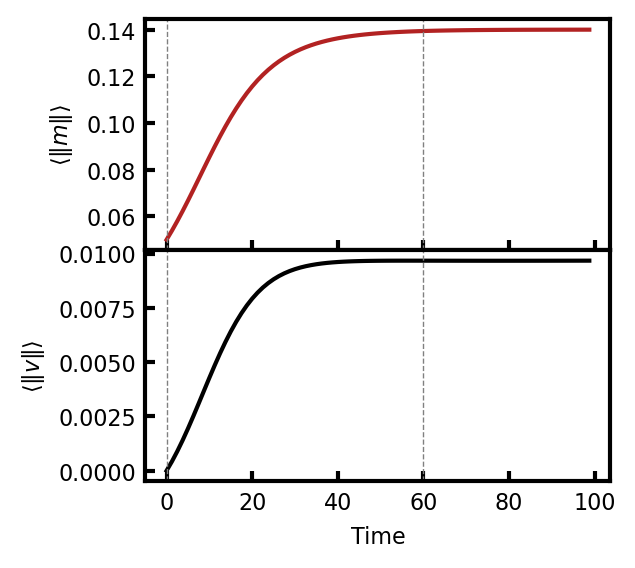

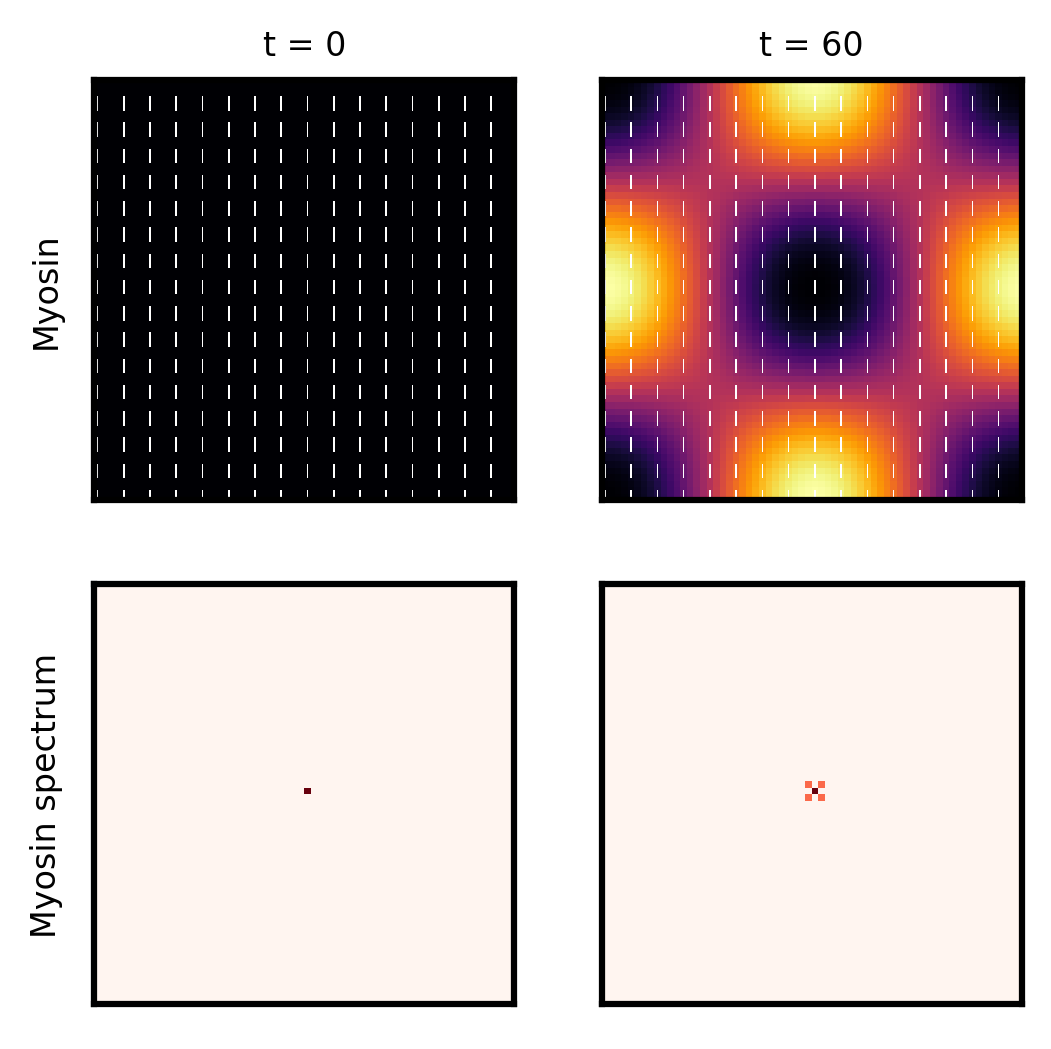

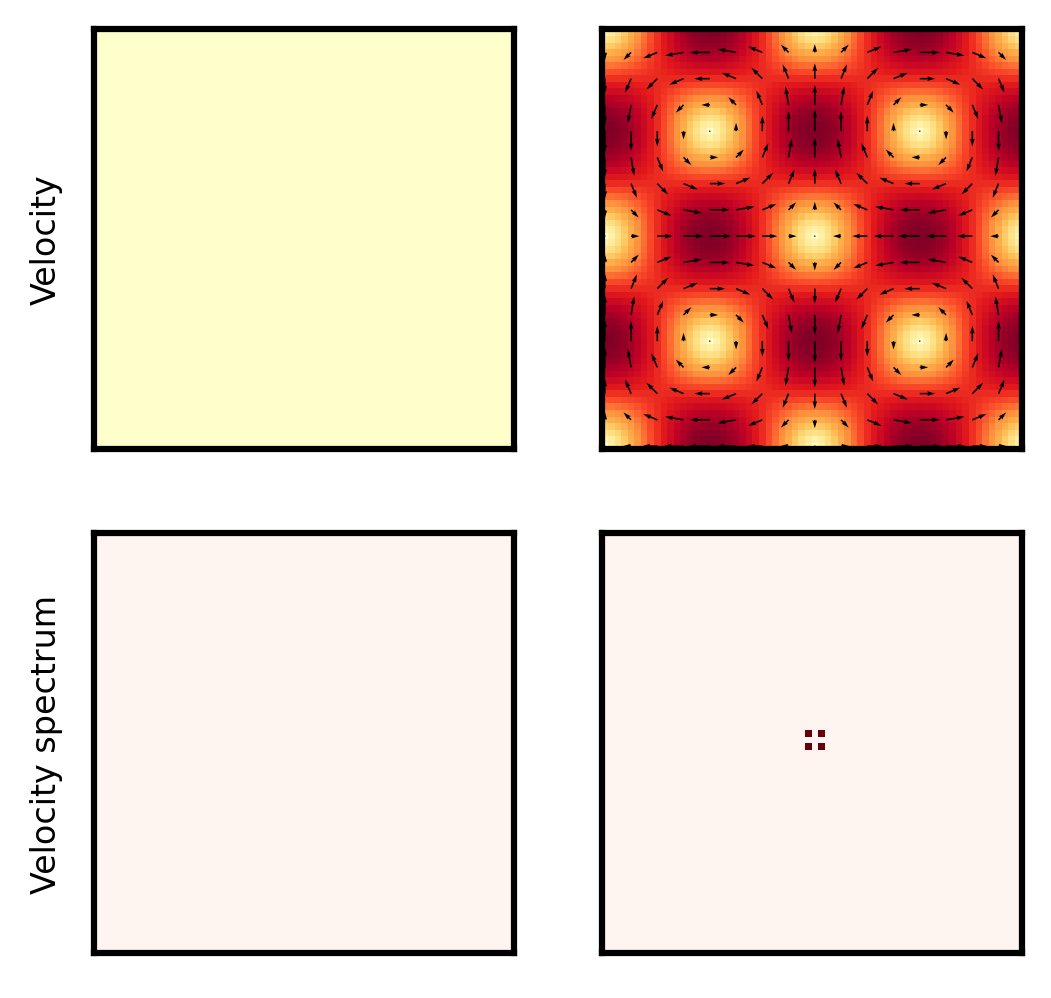

In [7]:
params = dict(
    Lx=1., Ly=1., Nx=64, Ny=64,
    am = 3, c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 0.,
    km = 0.6, kE = 0., 
    max_time=100, timestep=0.25, save_every=5,
)

simulate(params)
plot([0, 60], show_cadherin=False, skip=4)

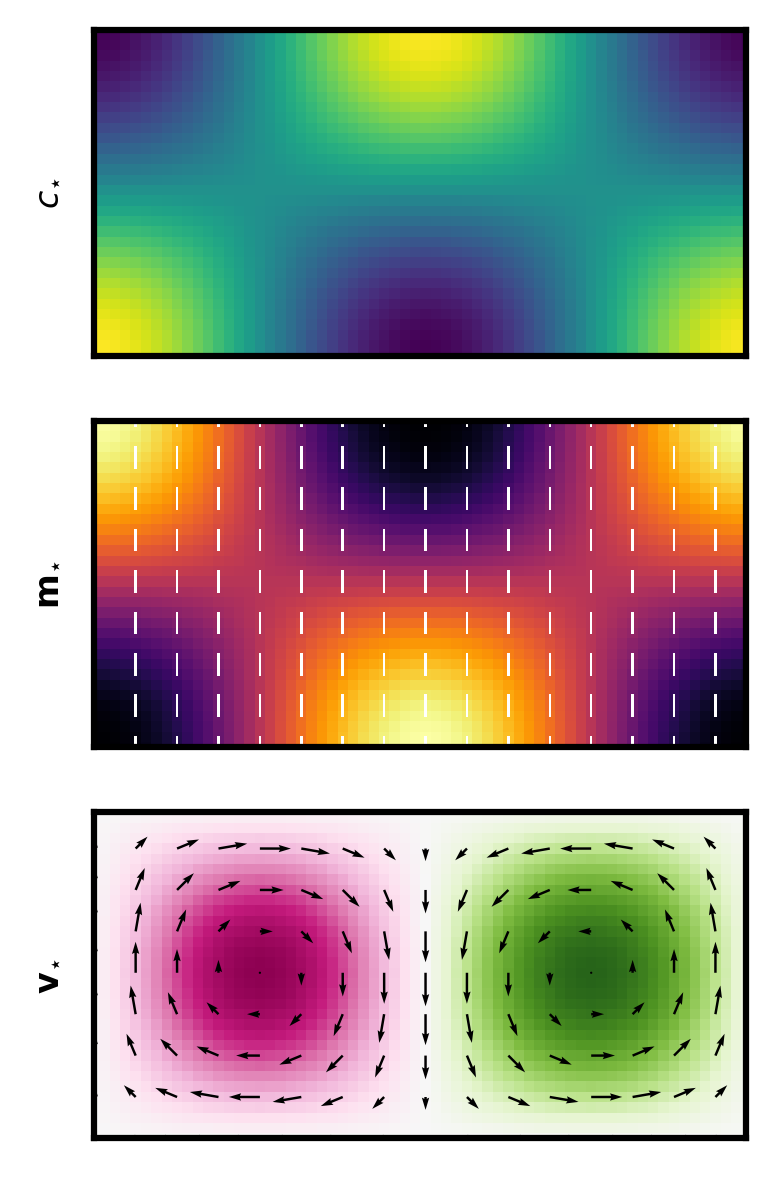

In [26]:
tt = 80
skip = 4
with h5py.File(f'FixedPoint/FixedPoint_s1.h5', 'r') as h5f:
    #Collect data
    t0  = h5f['scales/sim_time'][()]
    t0 = t0 - t0.min()
    idx = np.argmin(np.abs(t0 - tt))

    x = np.linspace(0, 1, h5f['tasks/m'].shape[-2])
    y = np.linspace(0, 1, h5f['tasks/m'].shape[-1])  
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    qmap = plt.cm.Reds
    qmap.set_bad(qmap(0))

    #Plot myosin
    fig, ax = plt.subplots(3, 1, dpi=300, sharex=True, sharey=True)       
    for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')

    m, n = get_director_magnitude(h5f['tasks/m'][idx])
    vmin, vmax = np.min(m), np.max(m)
    ax[1].pcolormesh(x, y, m.T, cmap='inferno', vmin=vmin, vmax=vmax)
    ax[1].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)

    vi = h5f['tasks/v'][idx]
    w = np.gradient(vi[1], axis=-2) - np.gradient(vi[0], axis=-1)
    vmax = np.max(np.abs(w))
    ax[2].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-vmax, vmax=vmax)
    ax[2].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, color="black")

    c = h5f['tasks/c'][idx]
    vmin, vmax = np.min(c), np.max(c)
    ax[0].pcolormesh(x, y, c.T, 
                        cmap='viridis', vmin=vmin, vmax=vmax)
    
    ax[0].set(xlim=[0, 1], ylim=[0, 0.5])
    ax[1].set_ylabel(r'$\mathbf{m}_{\star}$')
    ax[2].set_ylabel(r'$\mathbf{v}_{\star}$')
    ax[0].set_ylabel(r'$c_{\star}$')

    plt.savefig('NoAdvection_FP.png', dpi=300, bbox_inches='tight')

## 2. Re-establish convective derivative and observe leading-order harmonic behavior


### Advection
The convective derivative $\mathbf{v} \cdot \nabla m$ only has a $yy$ component - it corresponds to the advection of myosin density through the tissue. Its spectrum is
\begin{equation}
    \mathbf{v} \cdot \nabla m_{yy} (\mathbf{q}) = \begin{cases}
        -\frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        q^2 c_1^2 ,&\mathbf{q} = (0, \pm 2) \\
        \frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        q^2 c_1^2 ,&\mathbf{q} = (\pm 2, 0) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

2023-06-29 17:17:18,315 __main__ 0/1 INFO :: Adding advection term
0.7999999999999999 1.6
2023-06-29 17:17:18,466 __main__ 0/1 INFO :: Starting main loop
2023-06-29 17:17:18,515 __main__ 0/1 INFO :: Iteration=1, Time=0.25
2023-06-29 17:17:18,807 __main__ 0/1 INFO :: Iteration=101, Time=25.25
2023-06-29 17:17:19,094 __main__ 0/1 INFO :: Iteration=201, Time=50.25
2023-06-29 17:17:19,382 __main__ 0/1 INFO :: Iteration=301, Time=75.25
2023-06-29 17:17:19,671 __main__ 0/1 INFO :: Iteration=401, Time=100.25
2023-06-29 17:17:19,960 __main__ 0/1 INFO :: Iteration=501, Time=125.25
2023-06-29 17:17:20,247 __main__ 0/1 INFO :: Iteration=601, Time=150.25
2023-06-29 17:17:20,534 __main__ 0/1 INFO :: Iteration=701, Time=175.25
2023-06-29 17:17:20,812 solvers 0/1 INFO :: Simulation stop time reached.


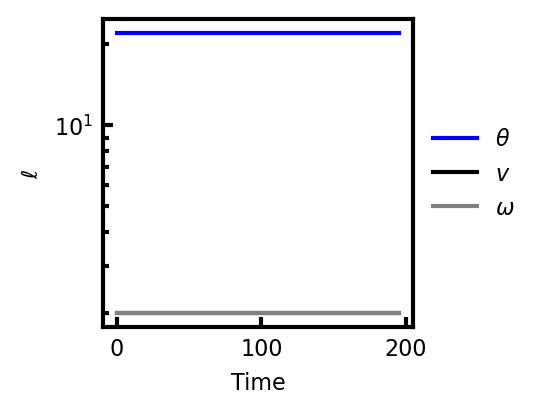

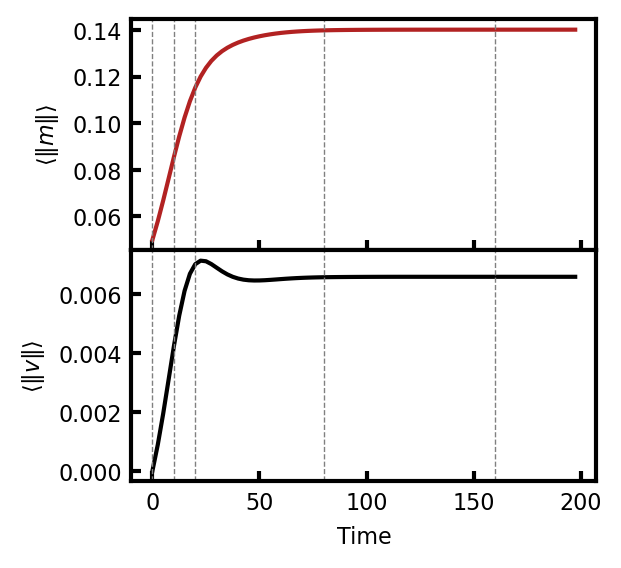

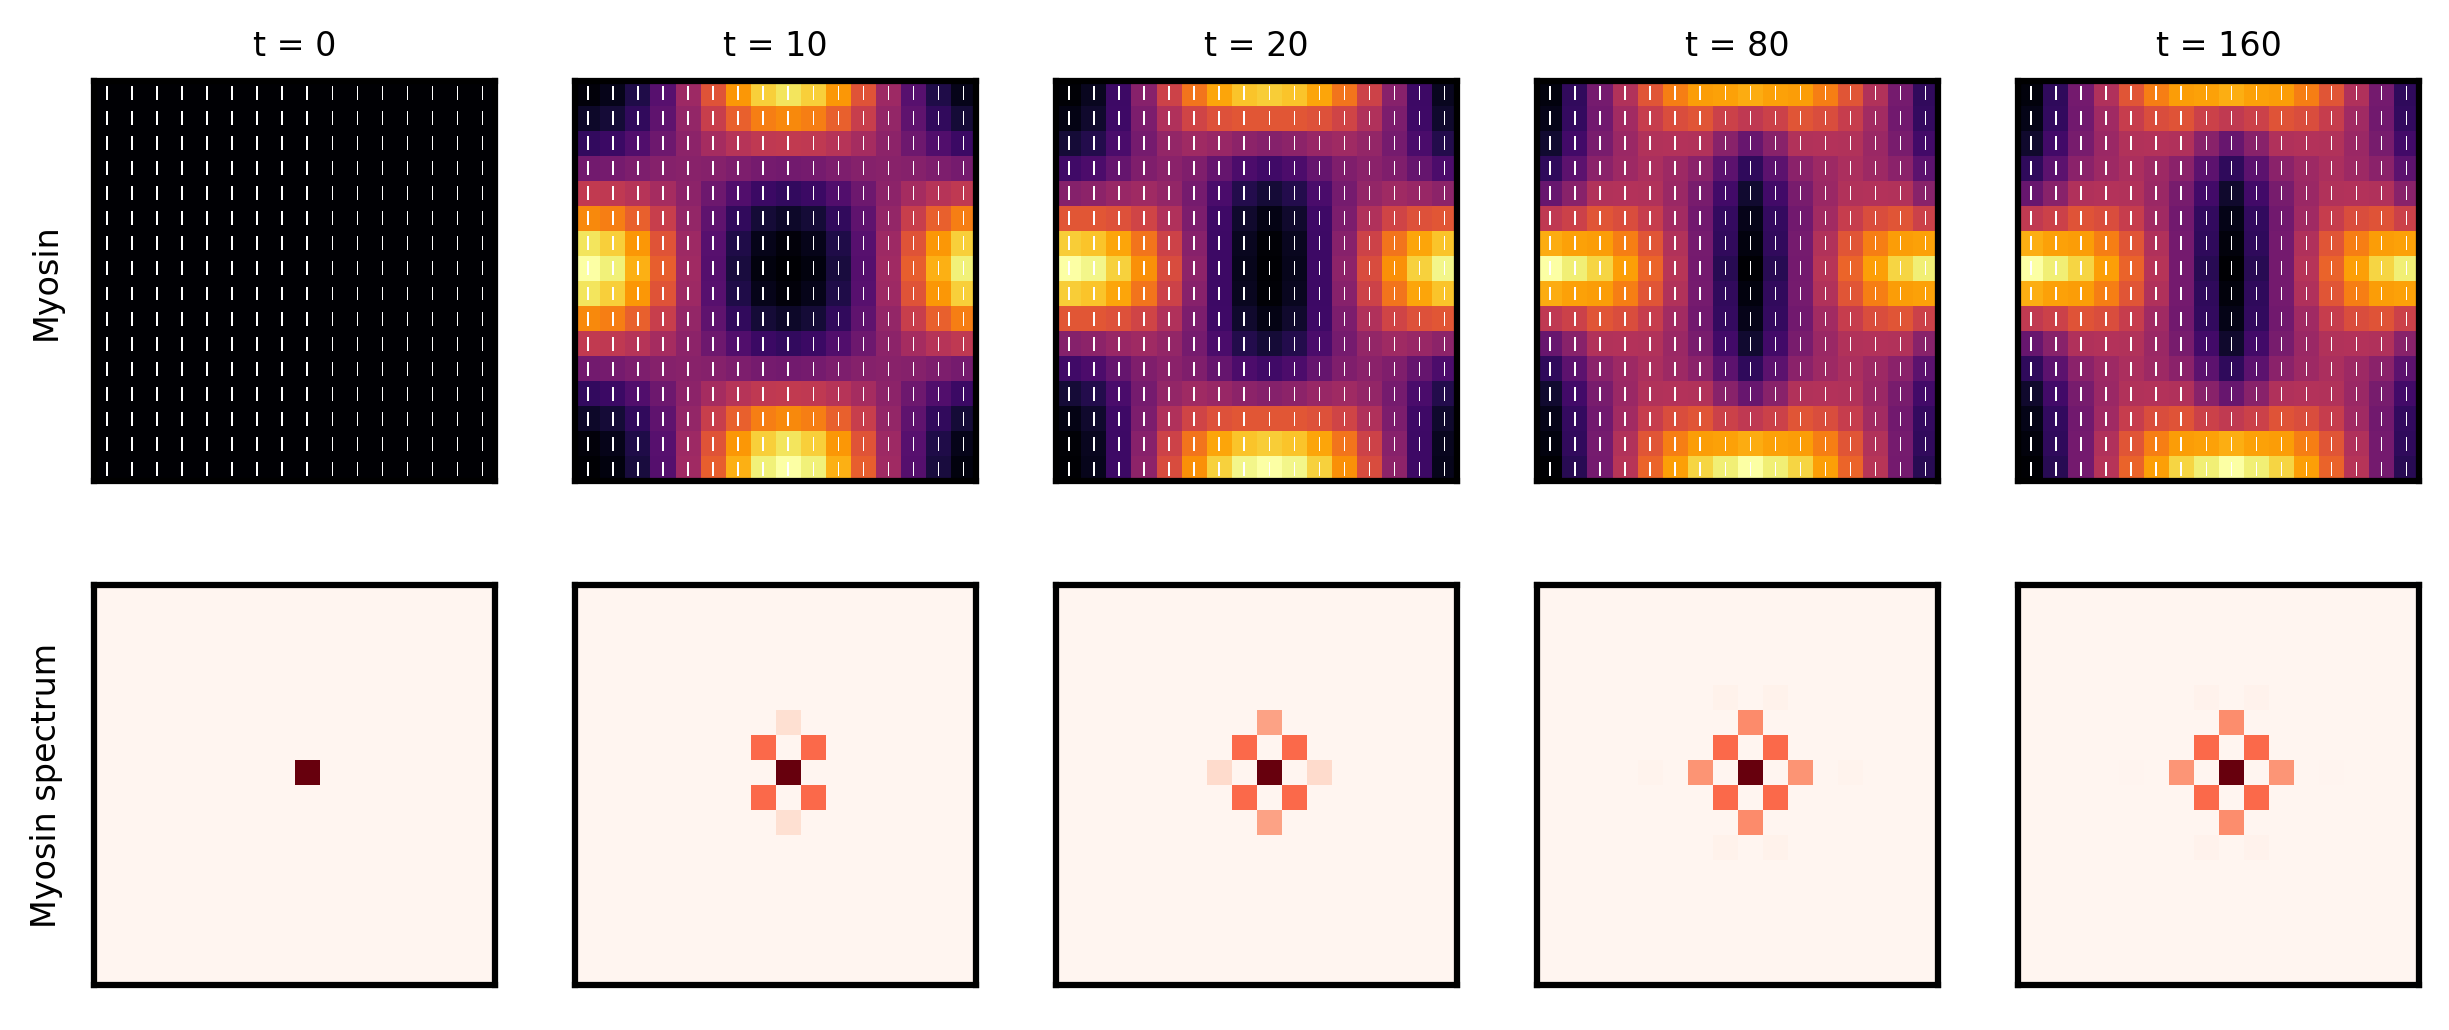

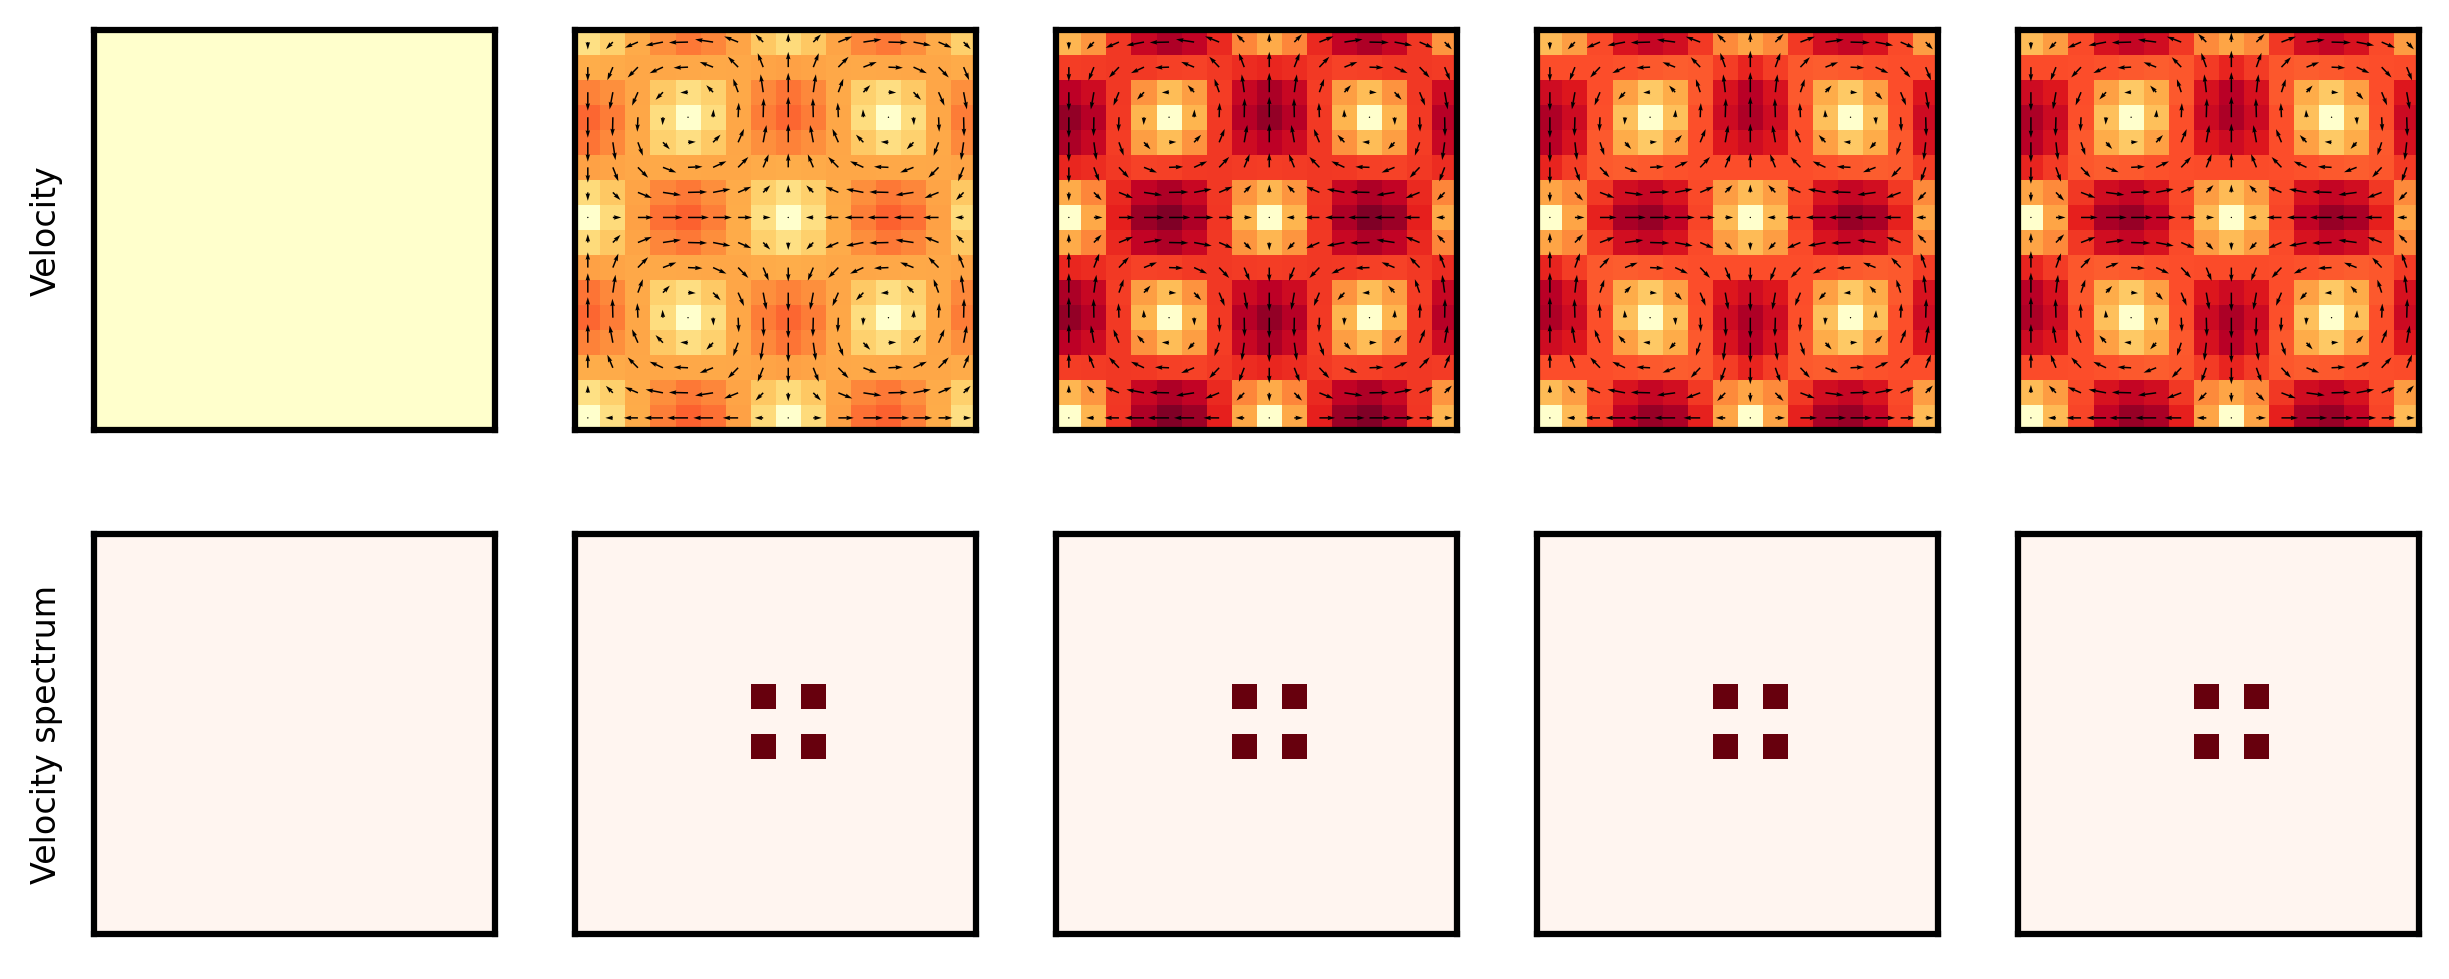

In [103]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4, #Define cadherin distribution and flow
    A = 1/3., B = -2/3., C = 0., #Coefficients for each term
    km = 0.6, kE = 0.,           #Cadherin modulated coefficeints
    adv=True, cor=False, use_FP=False,
    max_time=200, timestep=0.25, save_every=10,
)

simulate(params)
plot_correlations()
plot([0, 10, 20, 80, 160], show_cadherin=False)

### Co-rotation

The co-rotation term $[\Omega, m]_{ij} = \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj}$ is symmetric and has no diagonal component - co-rotation only re-orients the vector field rather than increasing density (trace). The spectrum of the vorticity is
\begin{equation}
    \Omega(\mathbf{q}) = \begin{cases}
        -\frac{\alpha k A}{16 \mu B} c_1 q_x q_y ,&\mathbf{q} = (\pm 1, \pm 1) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

which leads to the following spectrum for $[\Omega, m]$
\begin{equation}
    [\Omega, m]_{xy} (\mathbf{q}) = \begin{cases}
        \frac{\alpha}{\mu} \frac{k A^2}{8 B^2} \frac{q_x q_y}{q^2} (1 - k c_0)  c_1 
         ,&\mathbf{q} = (\pm 1, \pm 1) \\
        \frac{\alpha}{\mu} \left(\frac{k A}{8 B}\right)^2
        \frac{q_x q_y}{q^2} c_1^2 ,&\mathbf{q} = (\pm 2, \pm 2) \\
        0 ,& \text{otherwise}
    \end{cases}
\end{equation}

Note that each of the above nonlinearities introduces contributions at higher wavenumbers. However, only the co-rotation term induces an effect at the leading-order harmonics

2023-06-29 17:17:22,155 __main__ 0/1 INFO :: Adding co-rotation term
0.7999999999999999 1.6
2023-06-29 17:17:22,304 __main__ 0/1 INFO :: Starting main loop
2023-06-29 17:17:22,352 __main__ 0/1 INFO :: Iteration=1, Time=0.2
2023-06-29 17:17:22,660 __main__ 0/1 INFO :: Iteration=101, Time=20.19999999999996
2023-06-29 17:17:22,964 __main__ 0/1 INFO :: Iteration=201, Time=40.20000000000003
2023-06-29 17:17:23,259 solvers 0/1 INFO :: Simulation stop time reached.


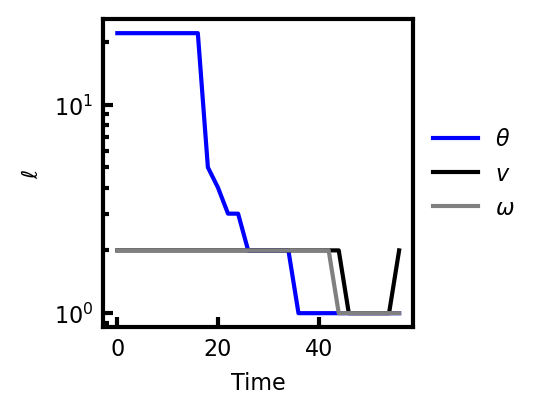

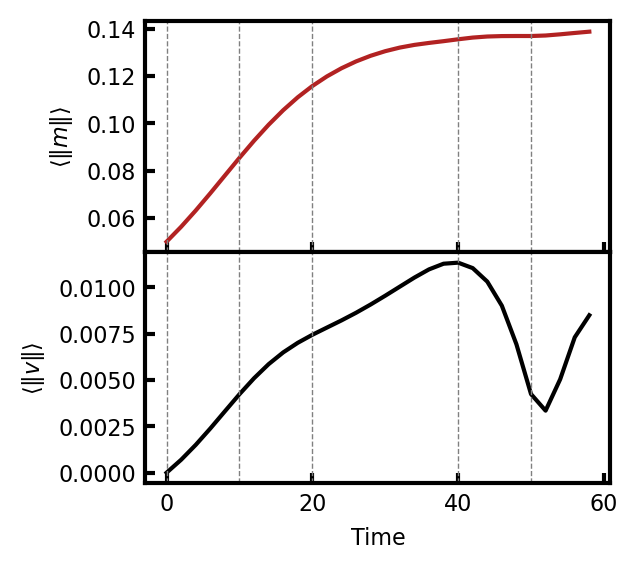

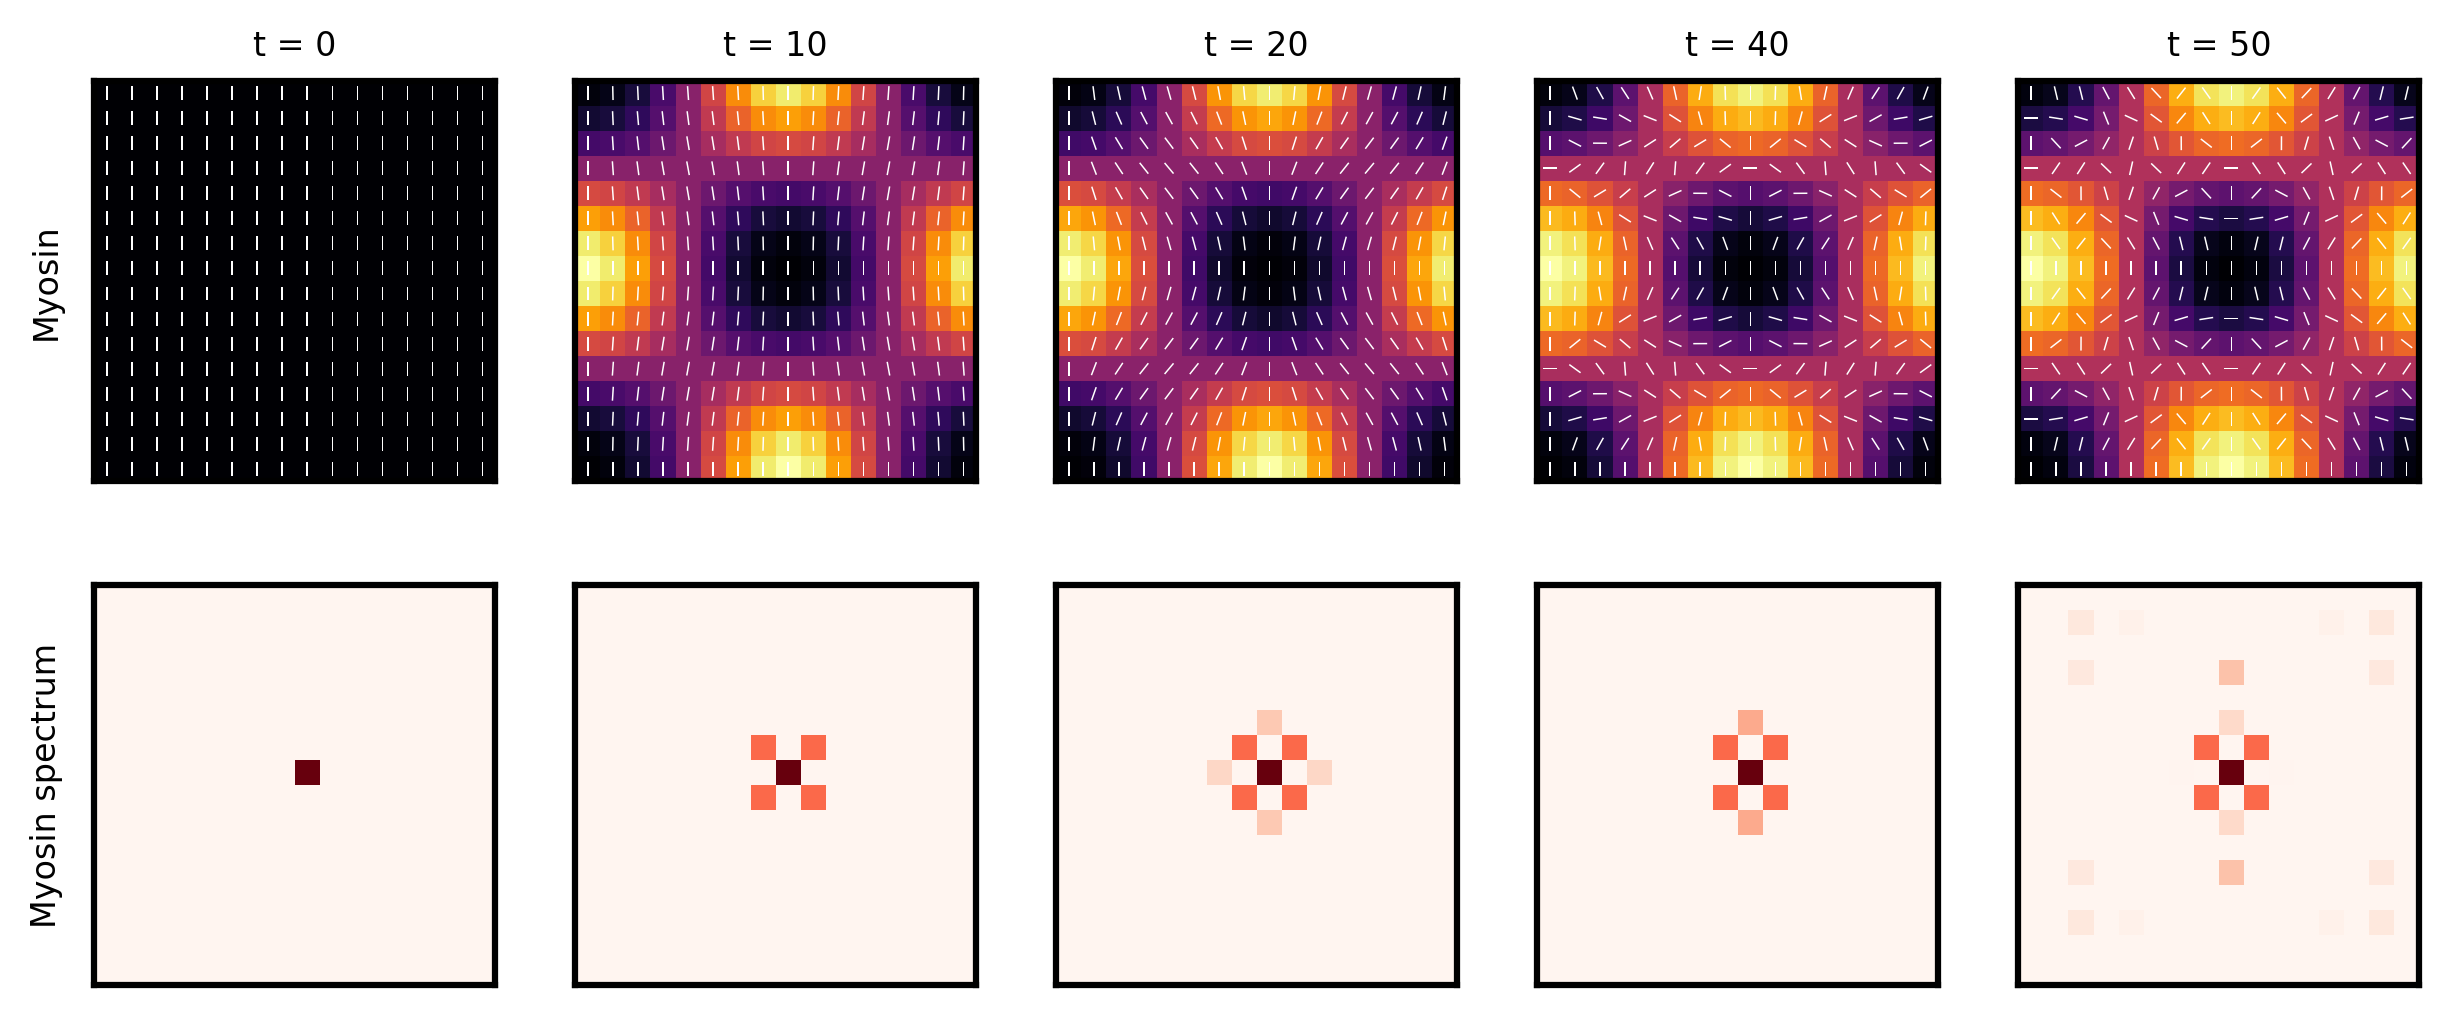

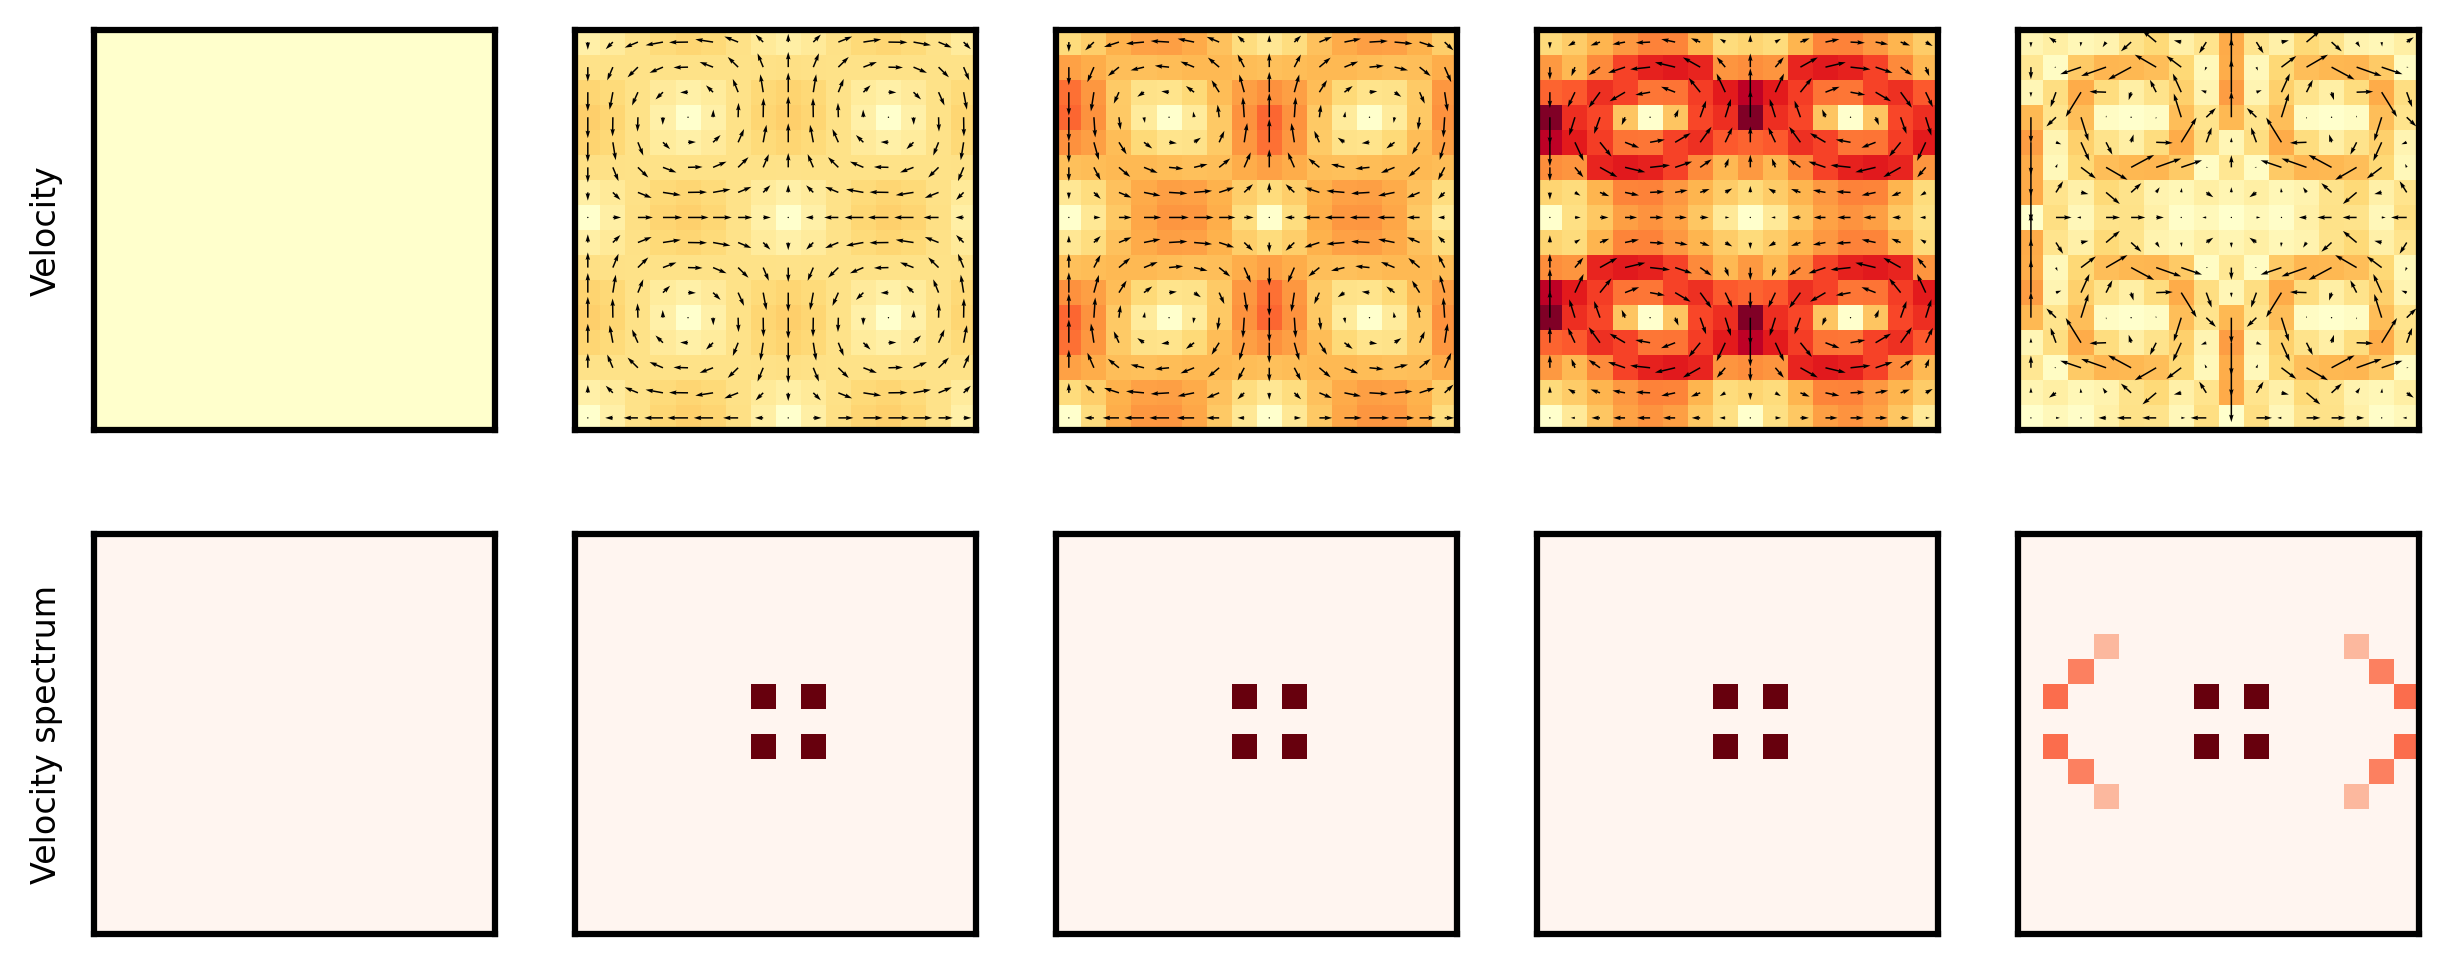

In [104]:
params = dict(
    Lx=1., Ly=1., Nx=16, Ny=16,
    am = 3., c0 = 1.2, c1 = 0.4, #Define cadherin distribution and flow
    A = 1/3., B = -2/3., C = 0., #Coefficients for each term
    km = 0.6, kE = 0.,           #Cadherin modulated coefficeints
    adv=False, cor=True, use_FP=False,
    max_time=60, timestep=0.2, save_every=10,
)

simulate(params)
plot_correlations()
plot([0, 10, 20, 40, 50], show_cadherin=False)

### Putting it all together

2023-06-30 12:00:58,679 __main__ 0/1 INFO :: Adding advection term
2023-06-30 12:00:58,679 __main__ 0/1 INFO :: Adding co-rotation term
0.7999999999999999 1.6
2023-06-30 12:00:59,348 __main__ 0/1 INFO :: Starting main loop
2023-06-30 12:00:59,434 __main__ 0/1 INFO :: Iteration=1, Time=0.2
2023-06-30 12:01:00,377 __main__ 0/1 INFO :: Iteration=101, Time=20.19999999999996
2023-06-30 12:01:01,295 __main__ 0/1 INFO :: Iteration=201, Time=40.20000000000003
2023-06-30 12:01:02,208 __main__ 0/1 INFO :: Iteration=301, Time=60.200000000000315
2023-06-30 12:01:02,656 solvers 0/1 INFO :: Simulation stop time reached.


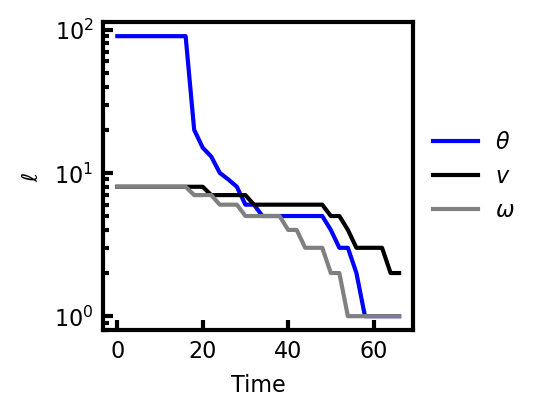

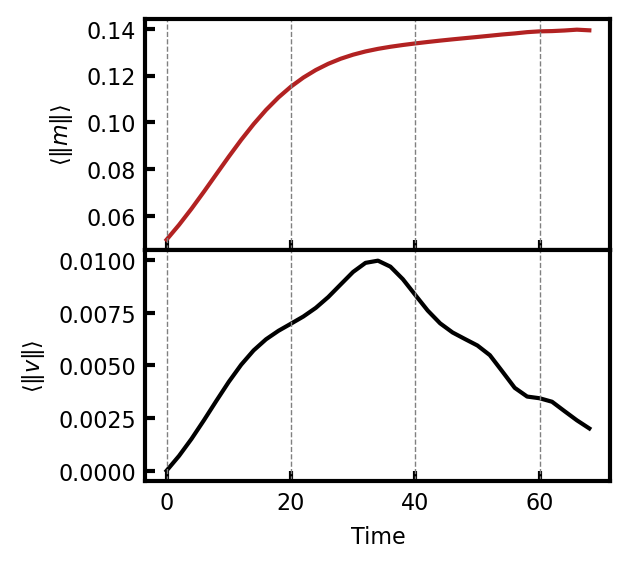

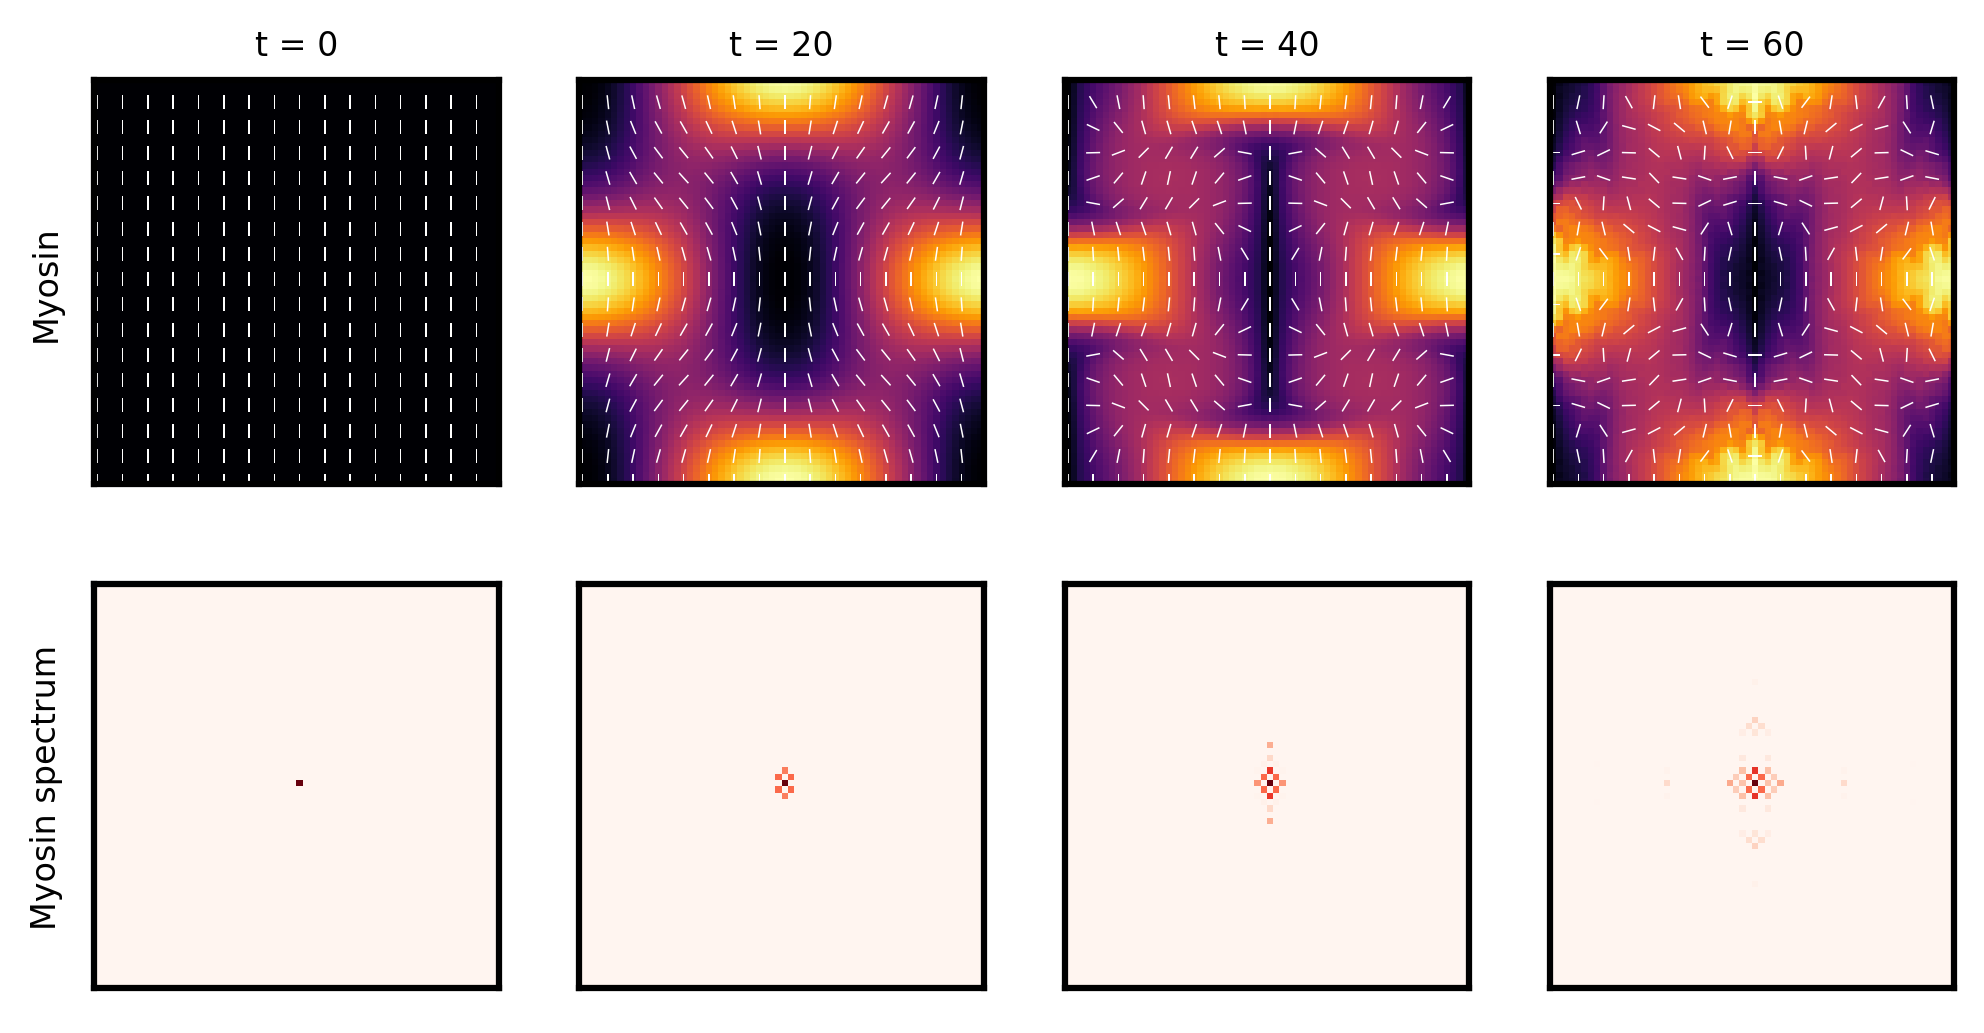

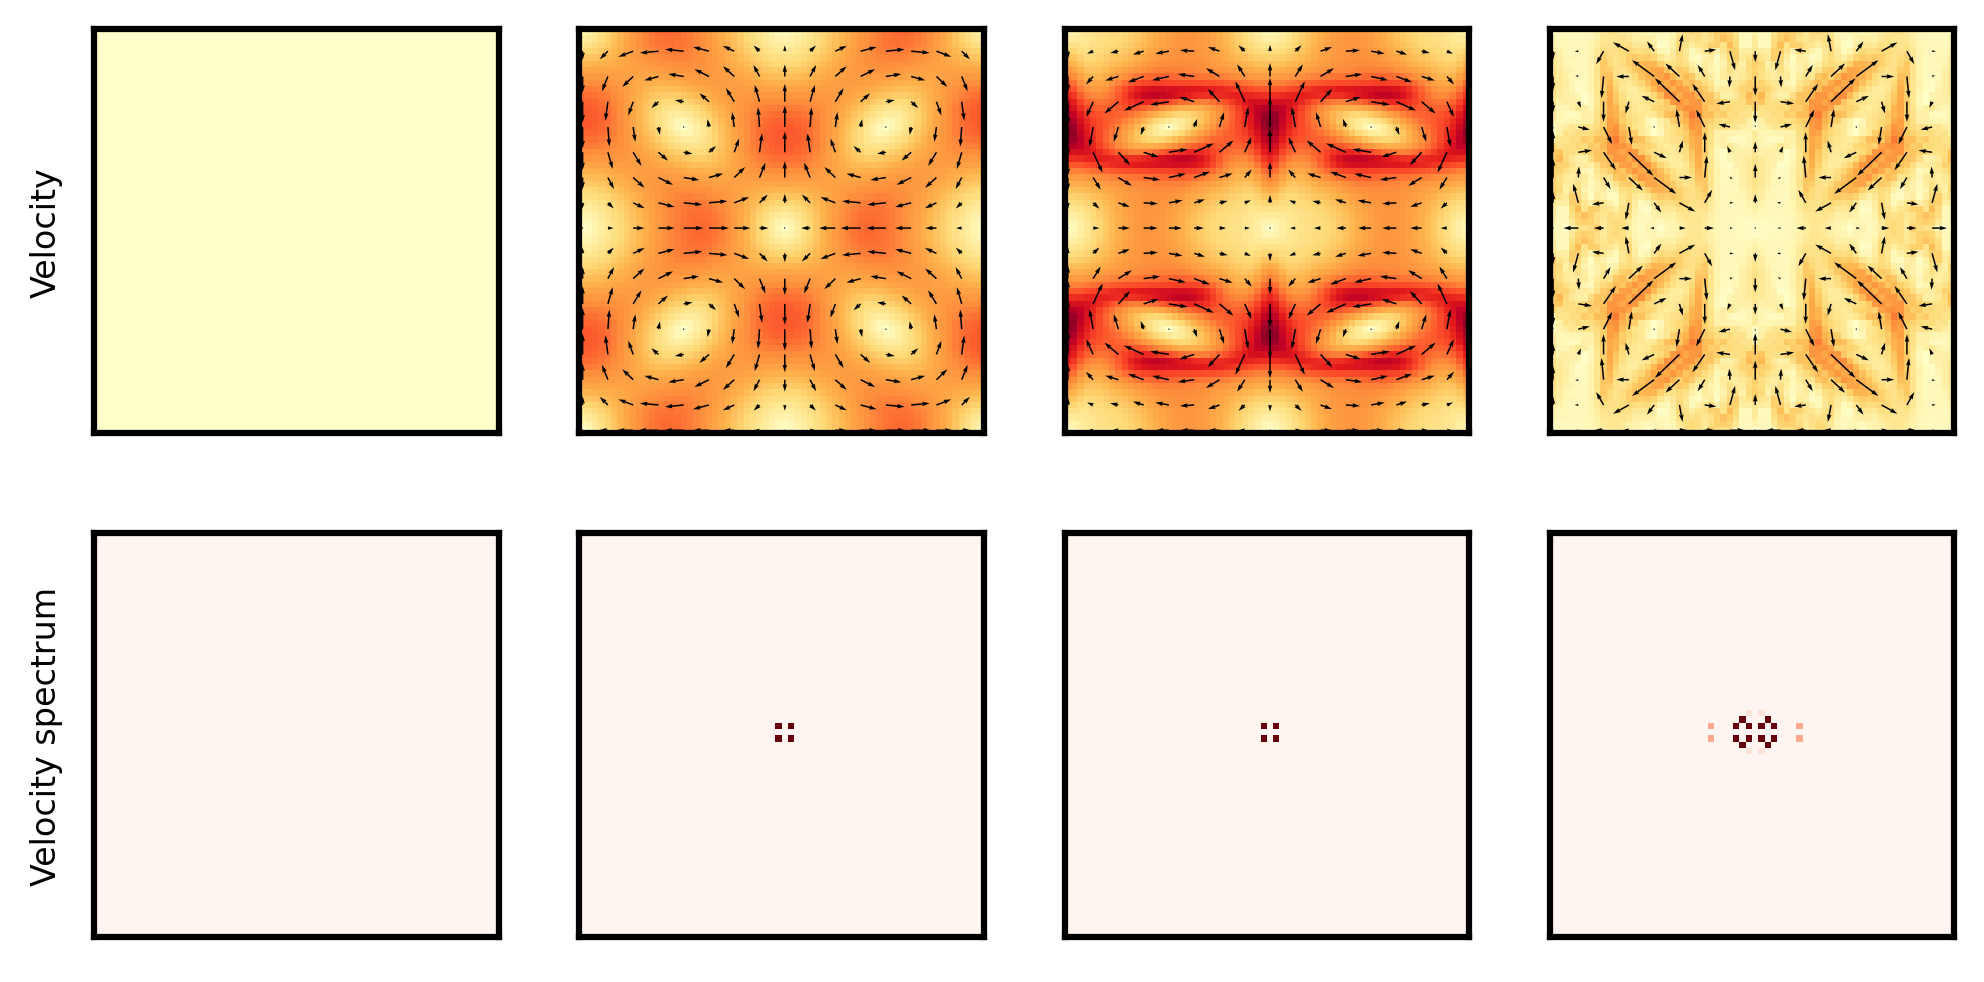

In [50]:
params = dict(
    Lx=1., Ly=1., #Nx=16, Ny=16,
    Nx=64, Ny=64,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 0,
    km = 0.6, kE = 0., 
    adv=True, cor=True, use_FP=False,
    max_time=70, timestep=0.2, save_every=10,
)

simulate(params)
plot_correlations(savename='With_Advection')
plot([0, 20, 40, 60], show_cadherin=False, skip=4)

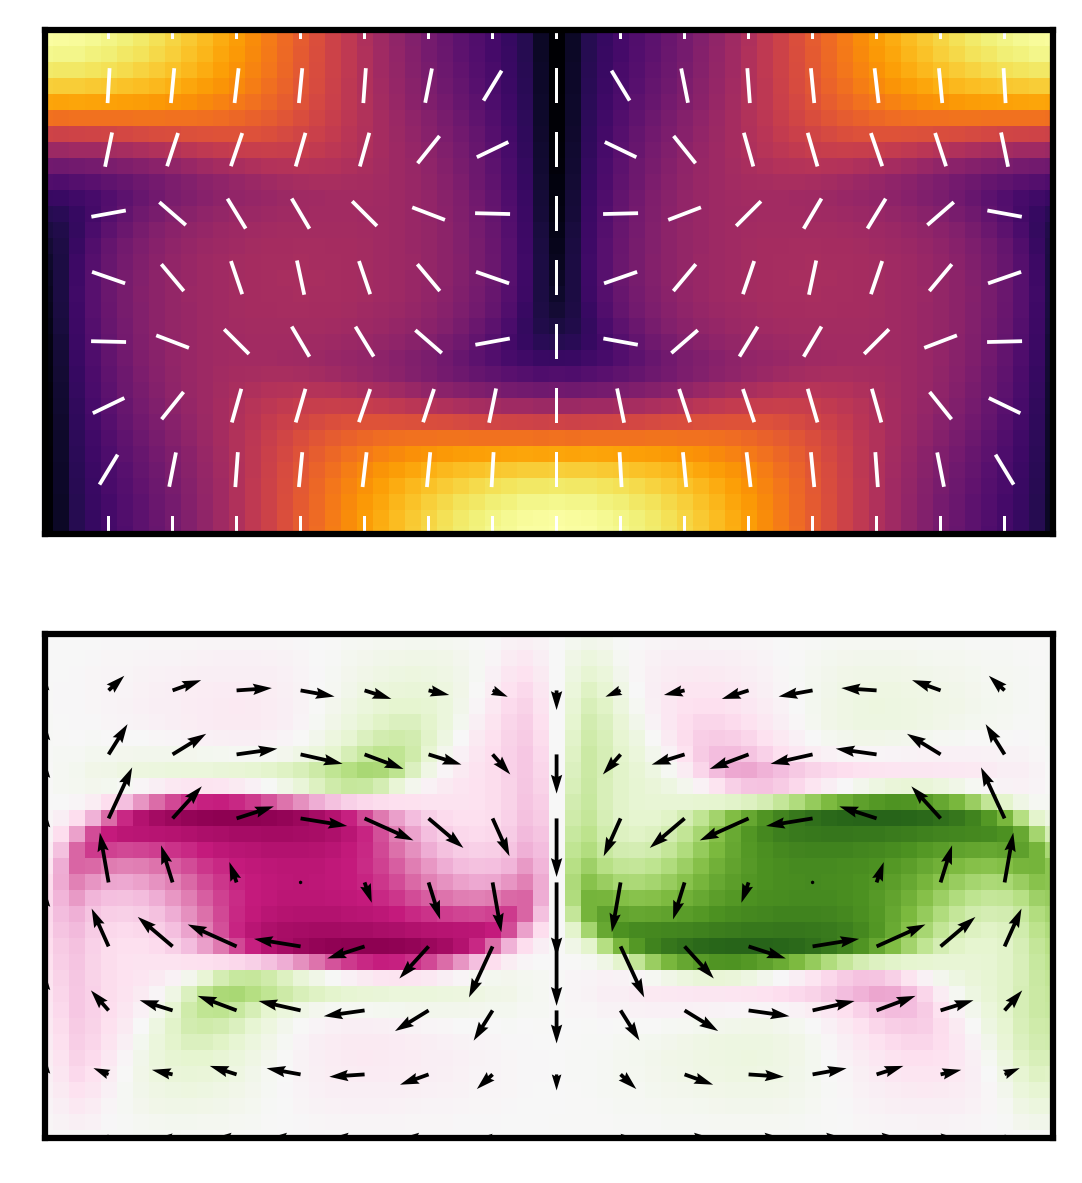

In [37]:
tt = 40
skip = 4
with h5py.File(f'FixedPoint/FixedPoint_s1.h5', 'r') as h5f:
    #Collect data
    t0  = h5f['scales/sim_time'][()]
    t0 = t0 - t0.min()
    idx = np.argmin(np.abs(t0 - tt))

    x = np.linspace(0, 1, h5f['tasks/m'].shape[-2])
    y = np.linspace(0, 1, h5f['tasks/m'].shape[-1])  
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    qmap = plt.cm.Reds
    qmap.set_bad(qmap(0))

    #Plot myosin
    fig, ax = plt.subplots(2, 1, dpi=300, sharex=True, sharey=True)       
    for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')

    m, n = get_director_magnitude(h5f['tasks/m'][idx])
    vmin, vmax = np.min(m), np.max(m)
    ax[0].pcolormesh(x, y, m.T, cmap='inferno', vmin=vmin, vmax=vmax)
    ax[0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)

    vi = h5f['tasks/v'][idx]
    w = np.gradient(vi[1], axis=-2) - np.gradient(vi[0], axis=-1)
    vmax = np.max(np.abs(w))
    ax[1].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-vmax, vmax=vmax)
    ax[1].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, color="black")
    
    ax[0].set(xlim=[0, 1], ylim=[0, 0.5])
    #ax[0].set_ylabel(r'$\mathbf{m}$')
    #ax[1].set_ylabel(r'$\mathbf{v}$')

    plt.savefig(f'With_Advection_{tt:d}.png', dpi=300, bbox_inches='tight')

## 3. Eliminate leading-order effects of convective derivative

The co-rotation term destroys orientational order by introducing a $\mathbf{q} = (\pm 1, \pm 1)$ off-diagonal component to the left-hand side. 

2023-06-29 17:17:30,260 __main__ 0/1 INFO :: Adding advection term
2023-06-29 17:17:30,261 __main__ 0/1 INFO :: Adding co-rotation term
0.7999999999999999 1.6
2023-06-29 17:17:30,941 __main__ 0/1 INFO :: Starting main loop
2023-06-29 17:17:31,032 __main__ 0/1 INFO :: Iteration=1, Time=0.2
2023-06-29 17:17:32,158 __main__ 0/1 INFO :: Iteration=101, Time=20.19999999999996
2023-06-29 17:17:33,323 __main__ 0/1 INFO :: Iteration=201, Time=40.20000000000003
2023-06-29 17:17:34,421 __main__ 0/1 INFO :: Iteration=301, Time=60.200000000000315
2023-06-29 17:17:34,959 solvers 0/1 INFO :: Simulation stop time reached.


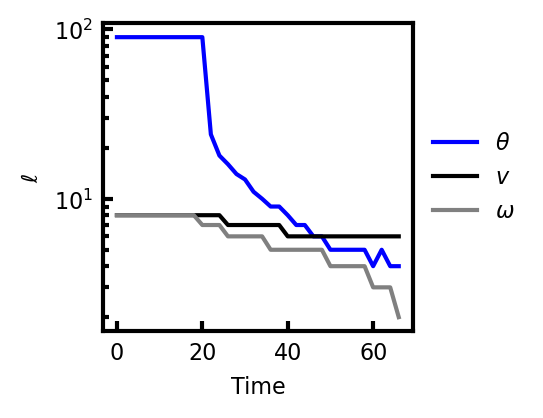

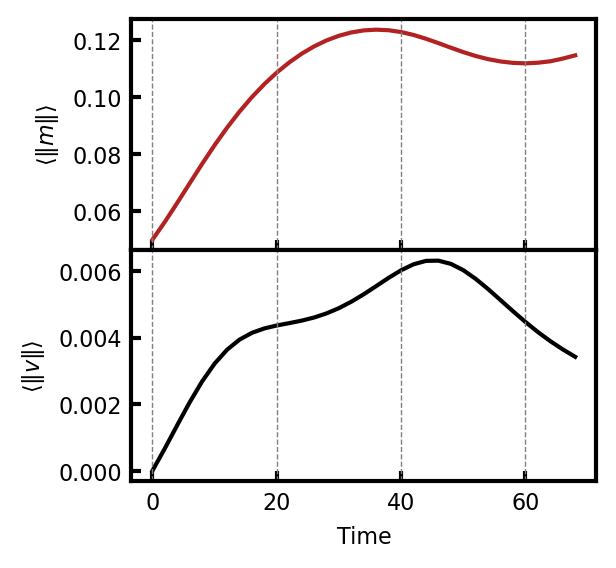

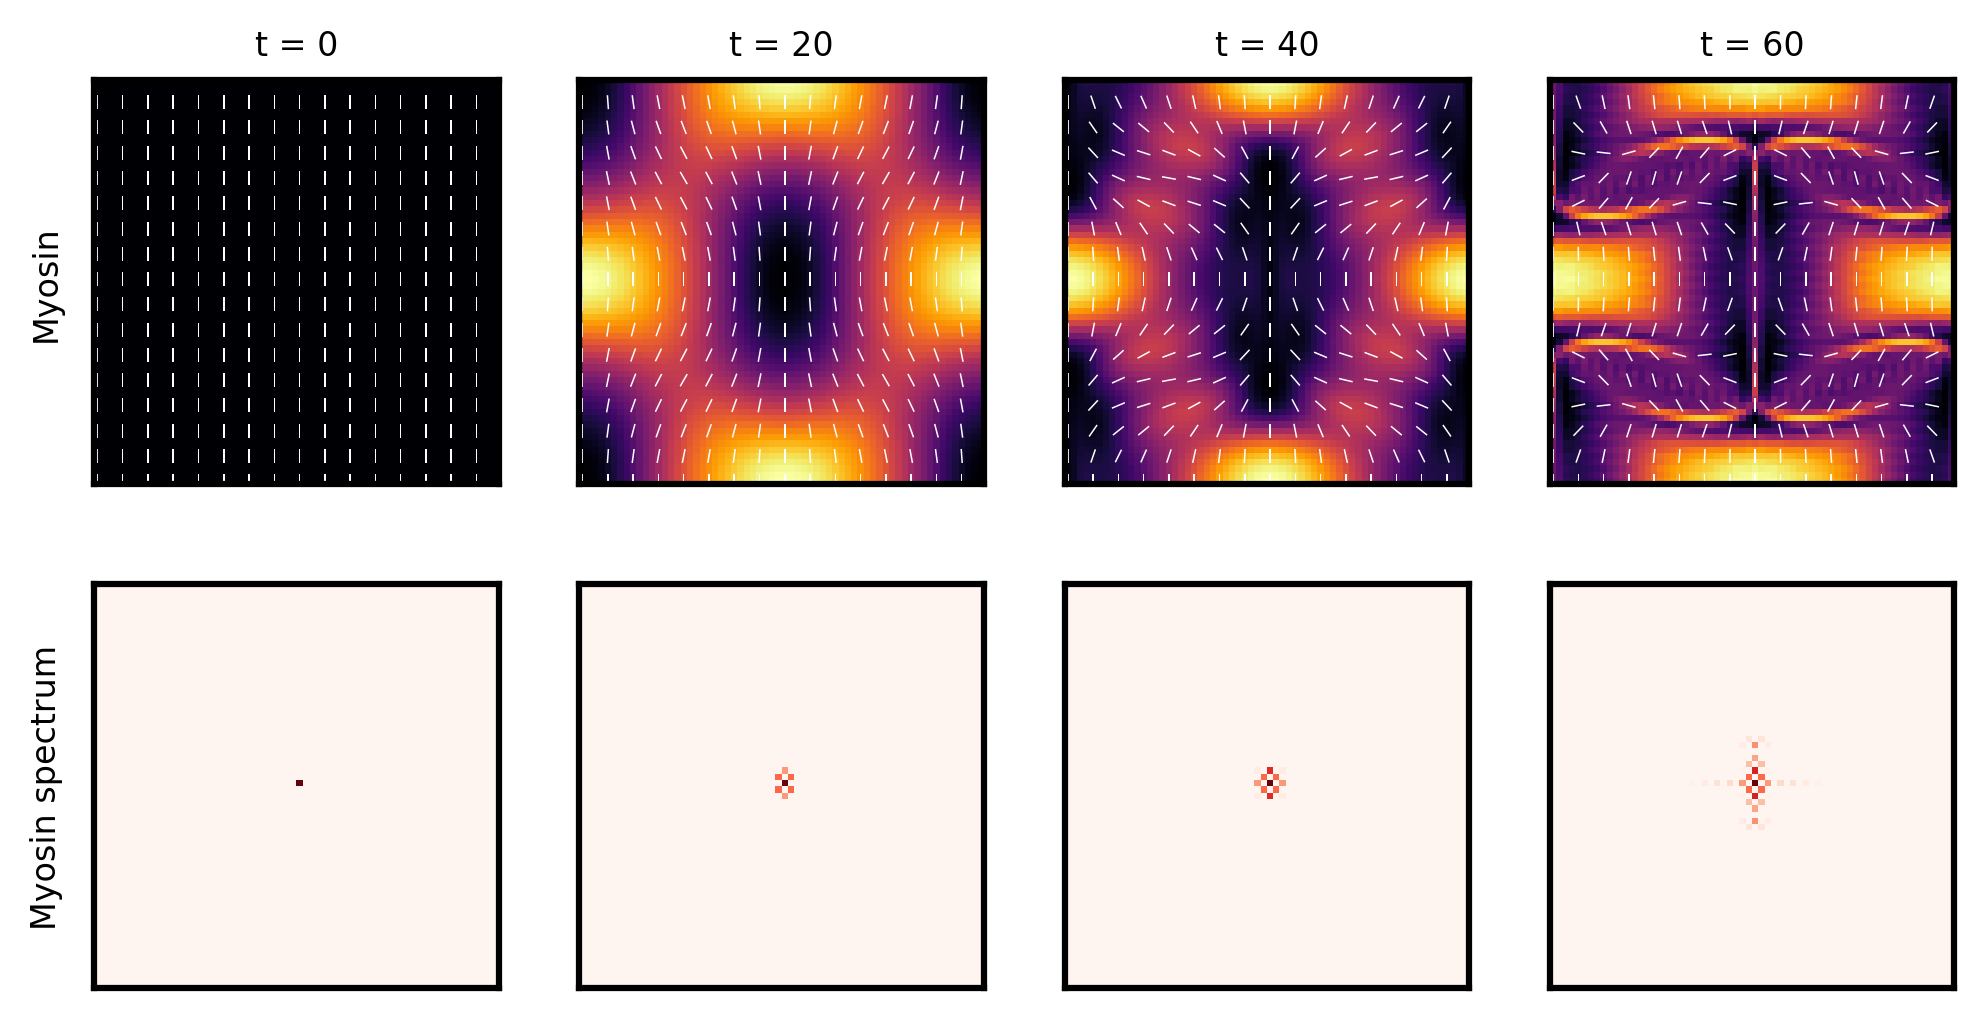

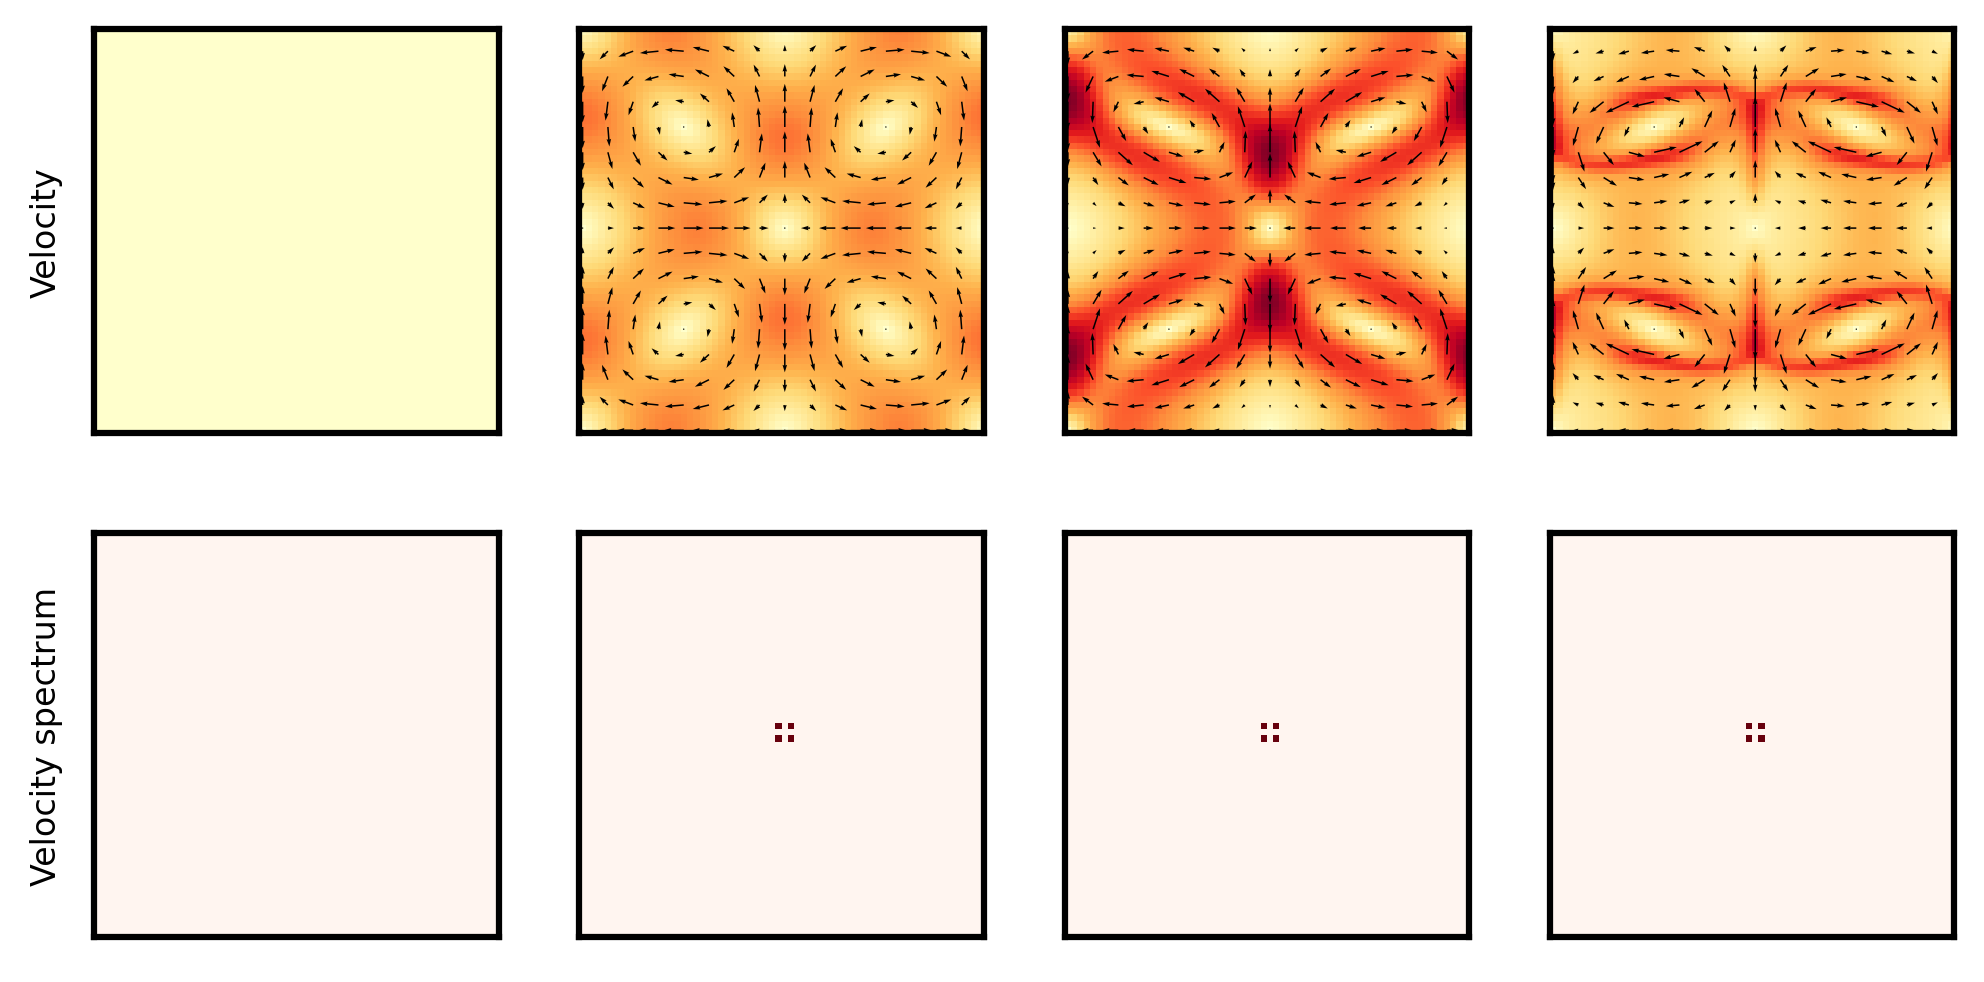

In [106]:
# (1 - c) type mechanical feedback

params = dict(
    Lx=1., Ly=1., #Nx=16, Ny=16,
    Nx=64, Ny=64,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = 0.4, 
    adv=True, cor=True, use_FP=False,
    max_time=70, timestep=0.2, save_every=10,
)

simulate(params)
plot_correlations()
plot([0, 20, 40, 60], show_cadherin=False, skip=4)

2023-06-30 12:01:04,994 __main__ 0/1 INFO :: Adding advection term
2023-06-30 12:01:04,995 __main__ 0/1 INFO :: Adding co-rotation term
0.7999999999999999 1.6
2023-06-30 12:01:05,664 __main__ 0/1 INFO :: Starting main loop
2023-06-30 12:01:05,752 __main__ 0/1 INFO :: Iteration=1, Time=0.2
2023-06-30 12:01:06,824 __main__ 0/1 INFO :: Iteration=101, Time=20.19999999999996
2023-06-30 12:01:07,871 __main__ 0/1 INFO :: Iteration=201, Time=40.20000000000003
2023-06-30 12:01:08,911 __main__ 0/1 INFO :: Iteration=301, Time=60.200000000000315
2023-06-30 12:01:09,487 solvers 0/1 INFO :: Simulation stop time reached.


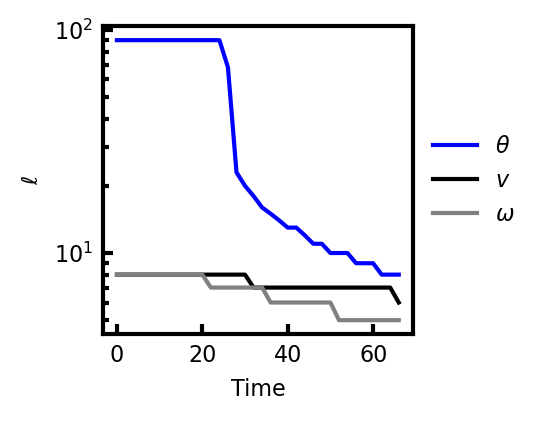

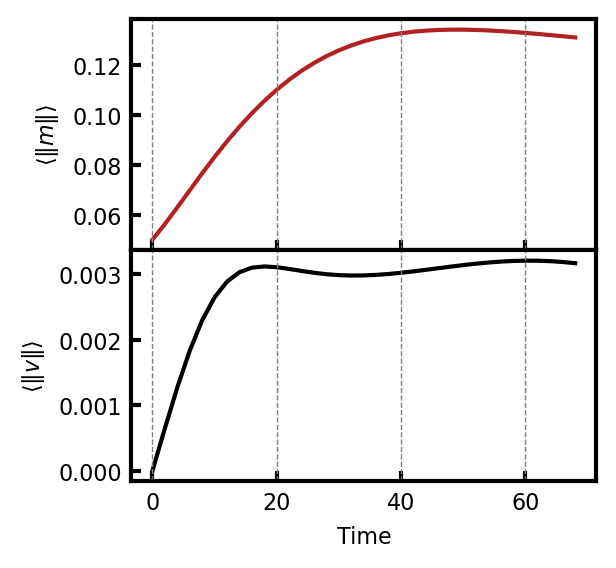

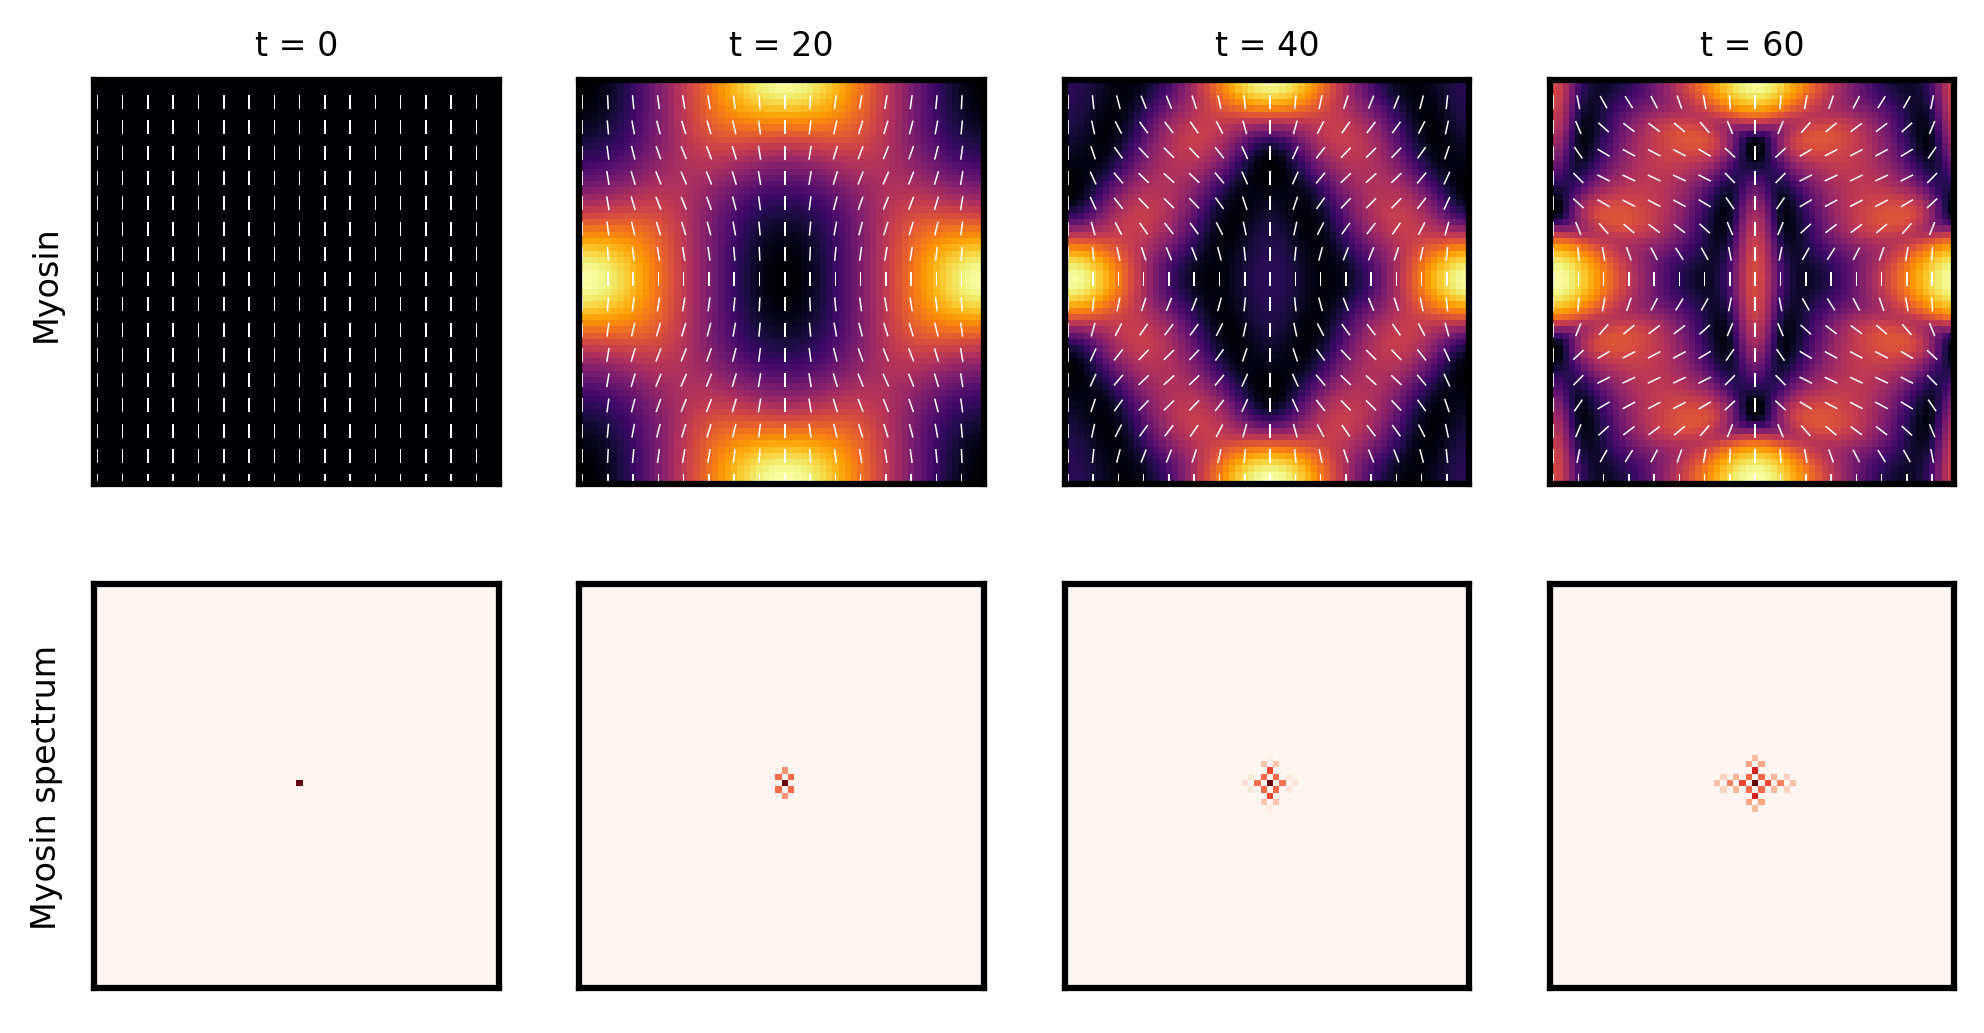

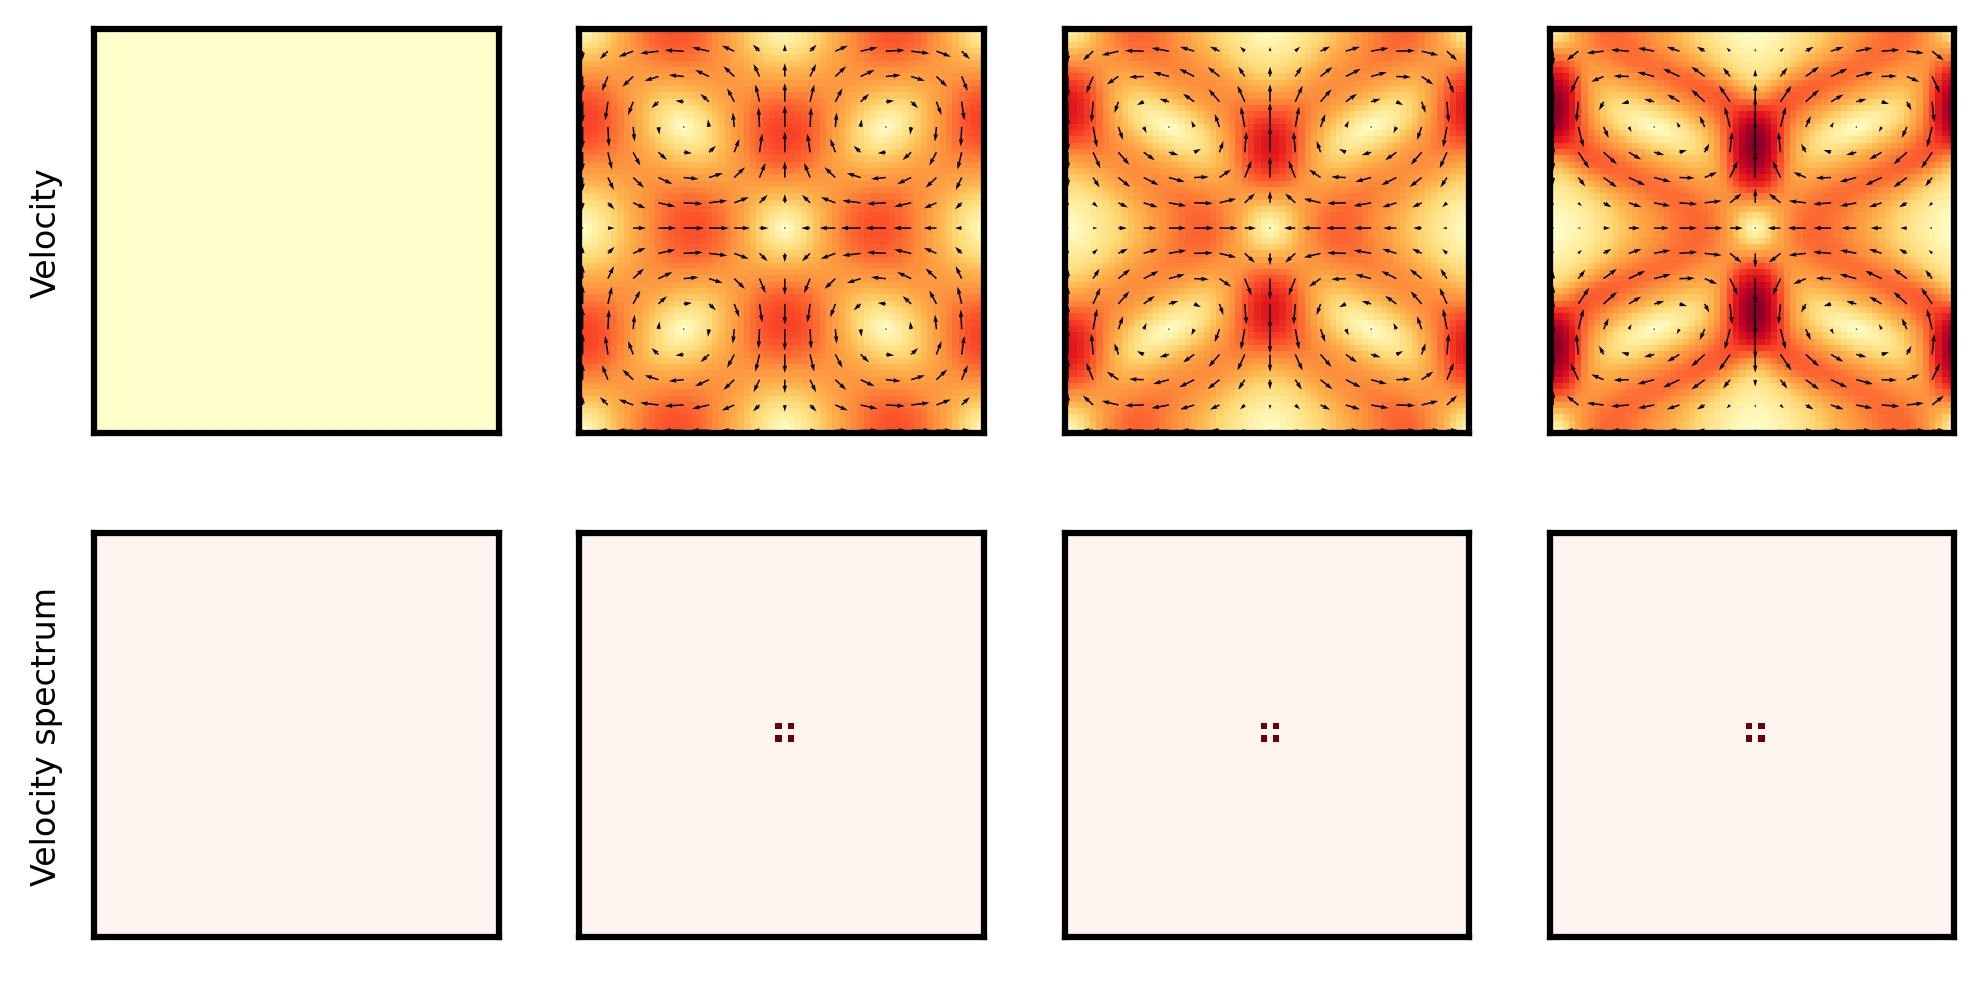

In [51]:
# (1) type mechanical feedback


params = dict(
    Lx=1., Ly=1., #Nx=16, Ny=16,
    Nx=64, Ny=64,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = 0.0, 
    adv=True, cor=True, use_FP=False,
    max_time=70, timestep=0.2, save_every=10,
)

simulate(params)
plot_correlations(savename='MechanicalFeedback')
plot([0, 20, 40, 60], show_cadherin=False, skip=4)

2023-06-30 12:01:31,589 __main__ 0/1 INFO :: Adding advection term
2023-06-30 12:01:31,590 __main__ 0/1 INFO :: Adding co-rotation term
0.7999999999999999 1.6
2023-06-30 12:01:32,258 __main__ 0/1 INFO :: Starting main loop
2023-06-30 12:01:32,348 __main__ 0/1 INFO :: Iteration=1, Time=0.2
2023-06-30 12:01:33,457 __main__ 0/1 INFO :: Iteration=101, Time=20.19999999999996
2023-06-30 12:01:34,568 __main__ 0/1 INFO :: Iteration=201, Time=40.20000000000003
2023-06-30 12:01:35,646 __main__ 0/1 INFO :: Iteration=301, Time=60.200000000000315
2023-06-30 12:01:36,198 solvers 0/1 INFO :: Simulation stop time reached.


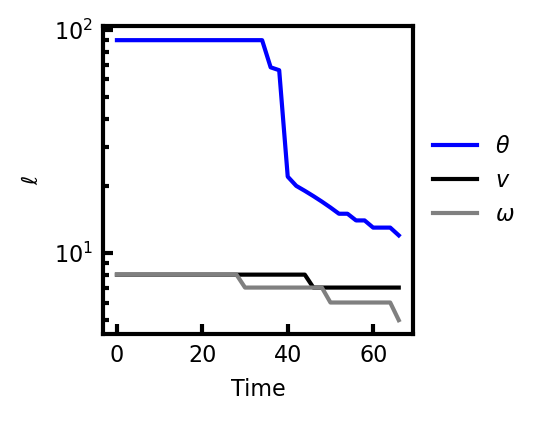

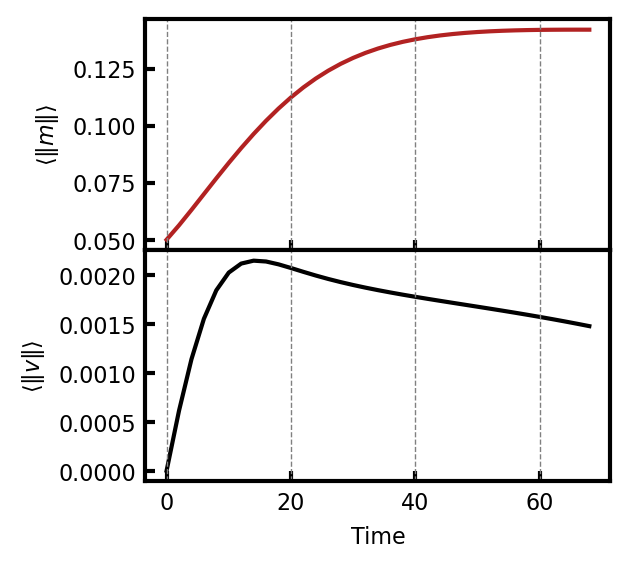

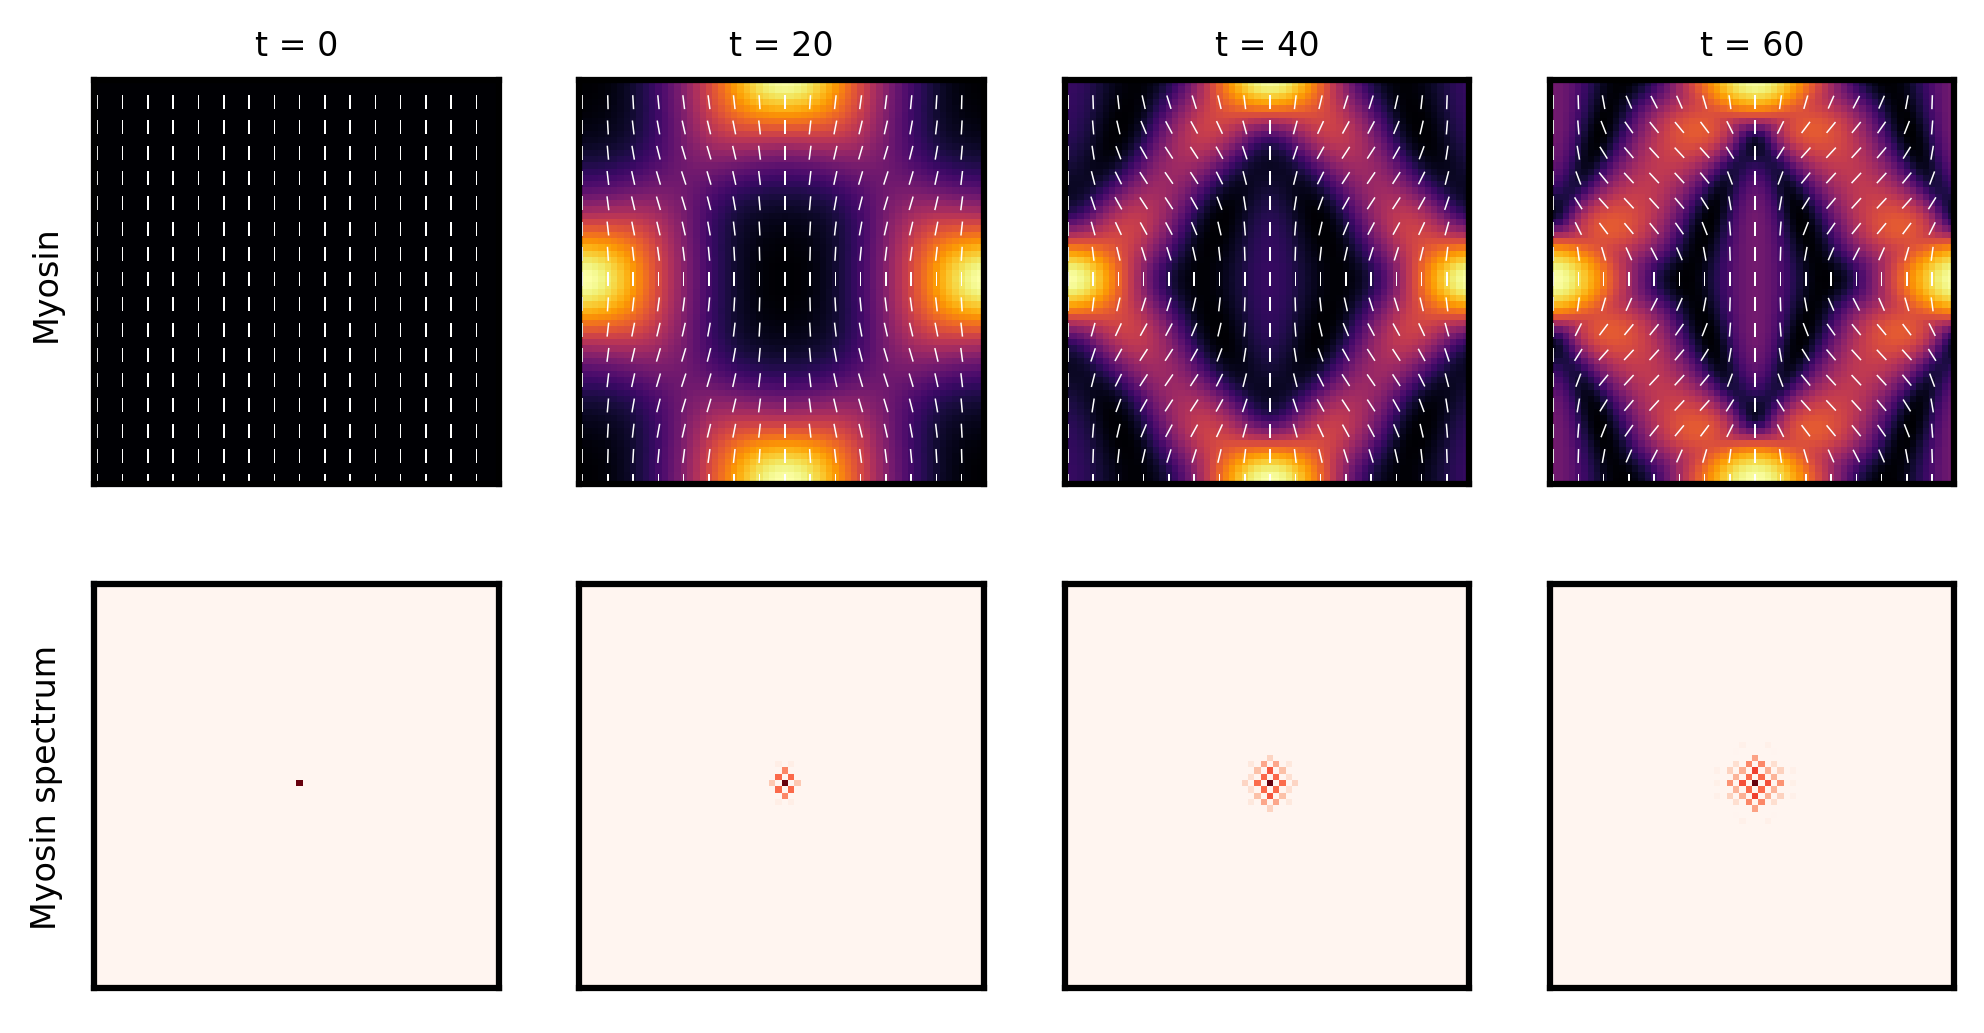

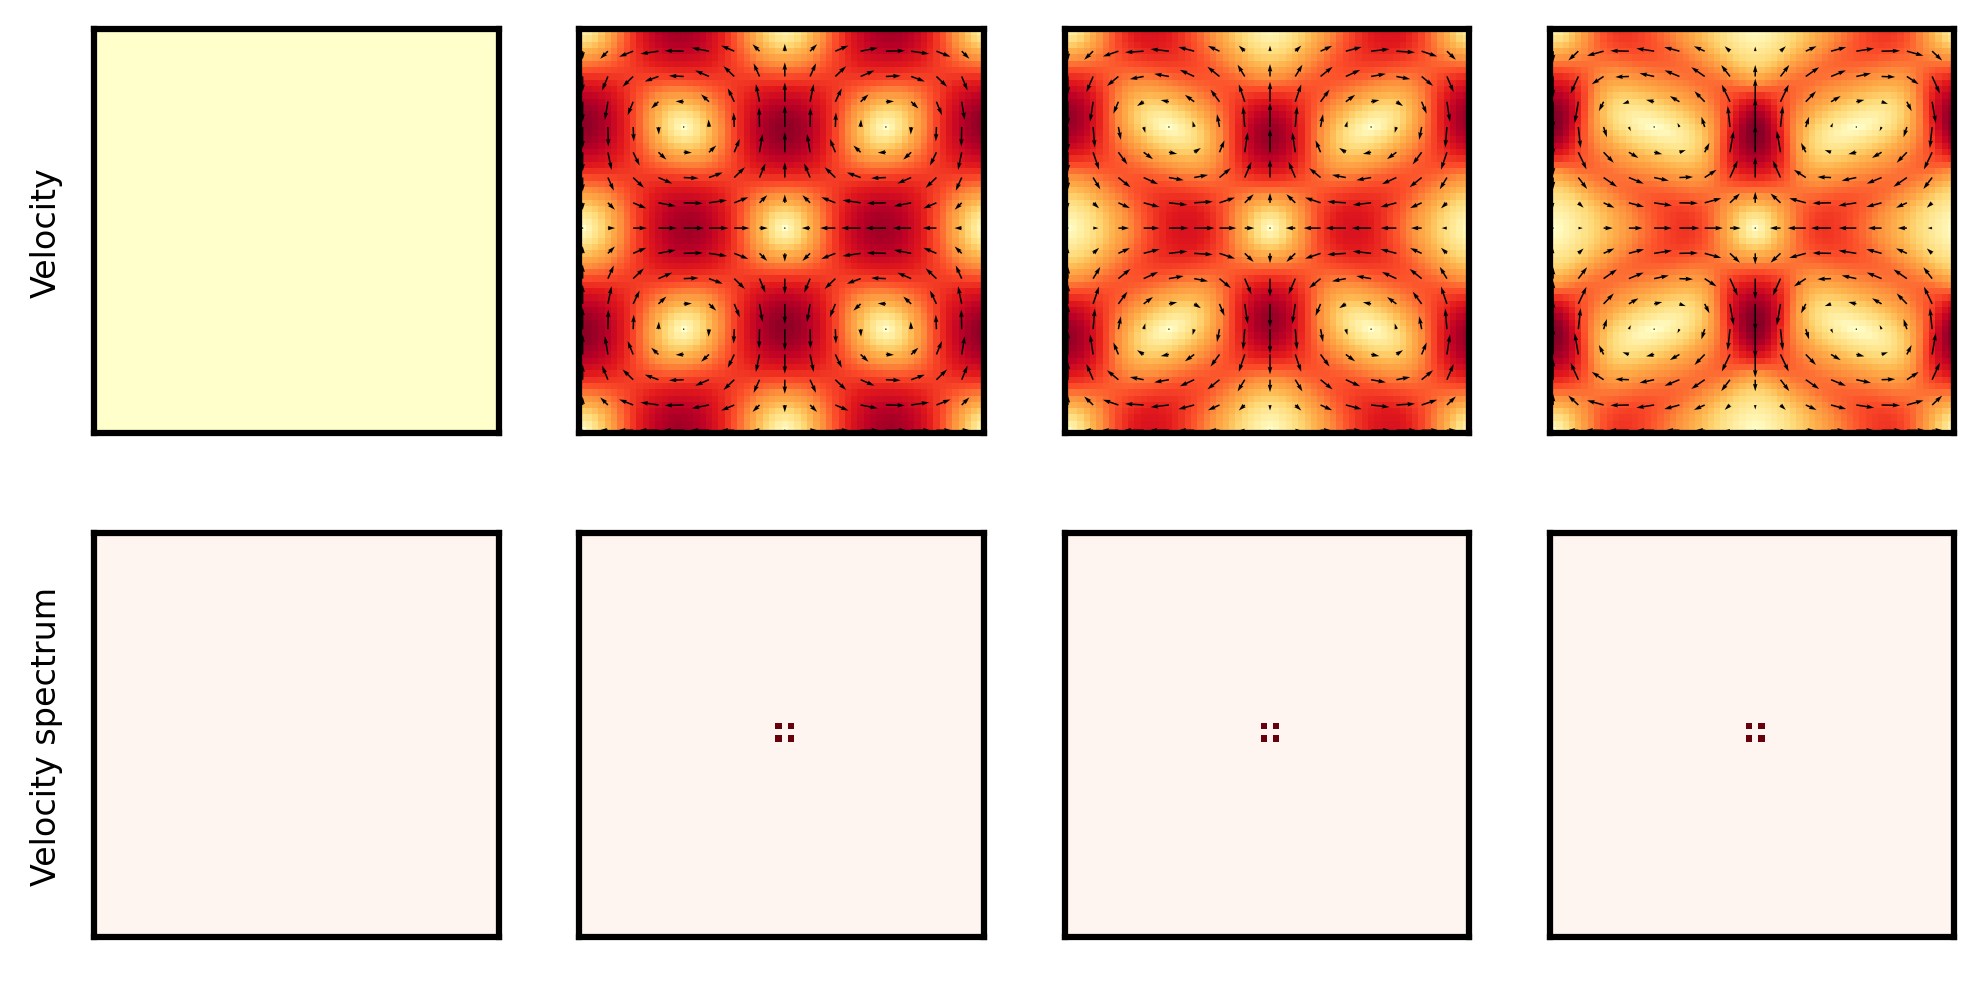

In [53]:
# (1 + c) type mechanical feedback


params = dict(
    Lx=1., Ly=1., #Nx=16, Ny=16,
    Nx=64, Ny=64,
    am = 3., c0 = 1.2, c1 = 0.4,
    A = 1/3., B = -2/3., C = 1,
    km = 0.6, kE = -0.6, 
    adv=True, cor=True, use_FP=False,
    max_time=70, timestep=0.2, save_every=10,
)

simulate(params)
plot_correlations(savename='MechanicalFeedback')
plot([0, 20, 40, 60], show_cadherin=False, skip=4)

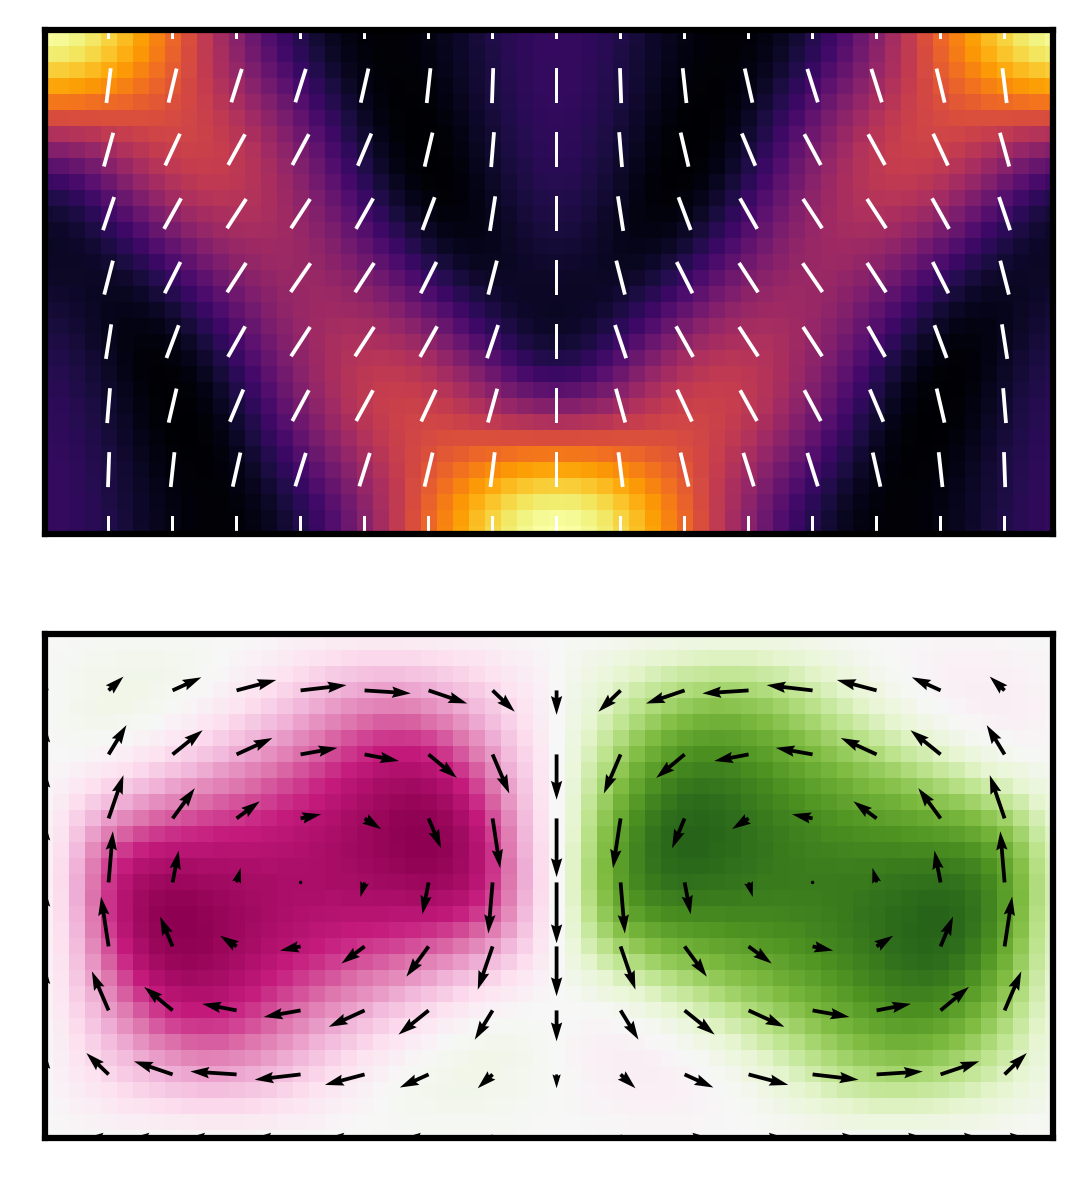

In [54]:
tt = 40
skip = 4
with h5py.File(f'FixedPoint/FixedPoint_s1.h5', 'r') as h5f:
    #Collect data
    t0  = h5f['scales/sim_time'][()]
    t0 = t0 - t0.min()
    idx = np.argmin(np.abs(t0 - tt))

    x = np.linspace(0, 1, h5f['tasks/m'].shape[-2])
    y = np.linspace(0, 1, h5f['tasks/m'].shape[-1])  
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    qmap = plt.cm.Reds
    qmap.set_bad(qmap(0))

    #Plot myosin
    fig, ax = plt.subplots(2, 1, dpi=300, sharex=True, sharey=True)       
    for a in ax.flatten(): a.set(xticks=[], yticks=[], aspect='equal')

    m, n = get_director_magnitude(h5f['tasks/m'][idx])
    vmin, vmax = np.min(m), np.max(m)
    ax[0].pcolormesh(x, y, m.T, cmap='inferno', vmin=vmin, vmax=vmax)
    ax[0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)

    vi = h5f['tasks/v'][idx]
    w = np.gradient(vi[1], axis=-2) - np.gradient(vi[0], axis=-1)
    vmax = np.max(np.abs(w))
    ax[1].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-vmax, vmax=vmax)
    ax[1].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, color="black")
    
    ax[0].set(xlim=[0, 1], ylim=[0, 0.5])
    #ax[0].set_ylabel(r'$\mathbf{m}$')
    #ax[1].set_ylabel(r'$\mathbf{v}$')

    plt.savefig(f'MechanicalFeedback_{tt:d}.png', dpi=300, bbox_inches='tight')

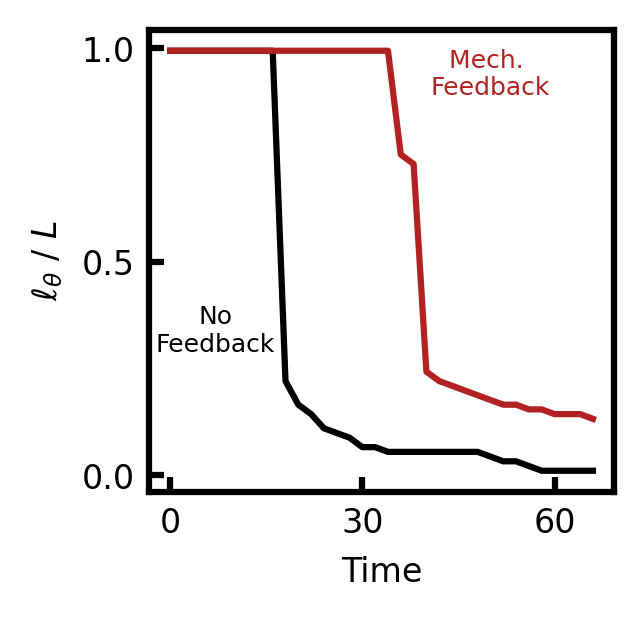

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
withAdv = np.load('With_Advection.npy')
mchFeed = np.load('MechanicalFeedback.npy')

t = np.arange(withAdv.shape[0]) * 2 #save_every=10, dt = 0.2
ax.plot(t, withAdv / (64 * np.sqrt(2)), color='black')
ax.plot(t, mchFeed / (64 * np.sqrt(2)), color='firebrick')
ax.set(xlabel='Time', ylabel=r'$\ell_{\theta} \ /\ L$',
       xticks=[0, 30, 60], yticks=[0, 0.5, 1])
ax.tick_params(which='both', direction='in', width=1.5)
ax.text(50, 1, 'Mech. \nFeedback', fontsize=6,
        va='top', ha='center', color='firebrick')
ax.text(7, .4, 'No\nFeedback', fontsize=6,
        va='top', ha='center', color='black')
plt.savefig('CorrelationLengths.png', bbox_inches='tight')